# ALeRCE API retrieval examples

Load libraries

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import os, sys

import requests
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

import pandas as pd
import seaborn as sns
#from pandas.io.json import json_normalize

#from collections import OrderedDict

from astropy.time import Time
from datetime import datetime
from IPython.display import HTML

import astropy.units as u
from astropy import coordinates

#from astroquery.ned import Ned
#from astroquery.simbad import Simbad
#from astropy.time import Time

#import json

from alerce.api import AlerceAPI

#!pip install psycopg2-binary
import psycopg2

from io import StringIO

/home/rodrigo/anaconda3/envs/tf1/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
import time
from astropy.time import Time

In [5]:
now = Time(datetime.utcnow(), scale='utc').datetime
now_mjd = Time(datetime.utcnow(), scale='utc').mjd

# Get fresh list of SNe sent to TNS by ALeRCE

In [6]:
def dourl(searchweb, searchoptions):
    url = searchweb
    for key in searchoptions.keys():
        url = "%s&%s=%s" % (url, key, searchoptions[key])
    return url

In [7]:
def get_tns_df(searchoptions):
    urlpage = dourl(searchweb,searchoptions)
    print(urlpage)
    s = requests.Session()
    response = s.get(urlpage)
    response.close()
    df = pd.read_csv(StringIO(response.text))
    urls = [f"http://alerce.online/object/{oid}" for oid in df['Disc. Internal Name']]
    df['url'] = urls
    return df

In [8]:
searchweb = "https://wis-tns.weizmann.ac.il/search?"
searchoptions = {
    "reporting_groupid[]": 74, # ALeRCE
    #"groupid": 74,
    #"discovery_data_source_id" : "48", # ZTF
    "num_page" : 500,  # 500 number of rows per page
    "format" : "csv",
    "display[remarks]":1,
}

In [9]:
all_alerce = []
page = 0
while True:
    print("Loading TNS page %i..." % page)
    searchoptions["page"] = page
    temp = get_tns_df(searchoptions)
    all_alerce.append(temp)
    if temp.shape[0] < 500:
        break
    page += 1
all_alerce = pd.concat(all_alerce)

Loading TNS page 0...
https://wis-tns.weizmann.ac.il/search?&reporting_groupid[]=74&num_page=500&format=csv&display[remarks]=1&page=0
Loading TNS page 1...
https://wis-tns.weizmann.ac.il/search?&reporting_groupid[]=74&num_page=500&format=csv&display[remarks]=1&page=1
Loading TNS page 2...
https://wis-tns.weizmann.ac.il/search?&reporting_groupid[]=74&num_page=500&format=csv&display[remarks]=1&page=2
Loading TNS page 3...
https://wis-tns.weizmann.ac.il/search?&reporting_groupid[]=74&num_page=500&format=csv&display[remarks]=1&page=3
Loading TNS page 4...
https://wis-tns.weizmann.ac.il/search?&reporting_groupid[]=74&num_page=500&format=csv&display[remarks]=1&page=4
Loading TNS page 5...
https://wis-tns.weizmann.ac.il/search?&reporting_groupid[]=74&num_page=500&format=csv&display[remarks]=1&page=5
Loading TNS page 6...
https://wis-tns.weizmann.ac.il/search?&reporting_groupid[]=74&num_page=500&format=csv&display[remarks]=1&page=6


In [10]:
all_alerce.shape

(3081, 25)

In [11]:
list(all_alerce)

['ID',
 'Name',
 'RA',
 'DEC',
 'Obj. Type',
 'Redshift',
 'Host Name',
 'Host Redshift',
 'Reporting Group/s',
 'Discovery Data Source/s',
 'Classifying Group/s',
 'Associated Group/s',
 'Disc. Internal Name',
 'Disc. Instrument/s',
 'Class. Instrument/s',
 'TNS AT',
 'Public',
 'End Prop. Period',
 'Discovery Mag/Flux',
 'Discovery Filter',
 'Discovery Date (UT)',
 'Sender',
 'Remarks',
 'Ext. catalog/s',
 'url']

In [12]:
sent = list(all_alerce["Disc. Internal Name"].values)

In [13]:
retracted = pd.read_csv("retracted.txt").oid.to_list()

### Remove retracted

In [14]:
all_alerce = all_alerce[~all_alerce["Disc. Internal Name"].isin(retracted)]

In [15]:
all_alerce.to_pickle("all_alerce.pkl")

In [16]:
all_alerce = pd.read_pickle("all_alerce.pkl")

In [17]:
classified_mask = ~(all_alerce["Classifying Group/s"].isna())

In [18]:
np.sum(classified_mask)

401

In [19]:
all_alerce.head()

,ID,Name,RA,DEC,Obj. Type,Redshift,Host Name,Host Redshift,Reporting Group/s,Discovery Data Source/s,...,TNS AT,Public,End Prop. Period,Discovery Mag/Flux,Discovery Filter,Discovery Date (UT),Sender,Remarks,Ext. catalog/s,url
0,62134,AT 2020ndt,12:08:13.563,-00:00:19.93,NaN,NaN,SDSS J120813.52-000019.7,0.171000,ALeRCE,ZTF,...,1,1,NaN,19.9761,g-ZTF,2020-06-21 05:07:56.001,ALeRCE,NaN,NaN,http://alerce.online/object/ZTF20abgvfrf
1,62133,AT 2020nds,13:14:59.471,+19:10:37.12,NaN,NaN,WISEA J131459.44+191036.8,0.128104,ALeRCE,ZTF,...,1,1,NaN,20.1248,r-ZTF,2020-06-21 05:42:52.998,ALeRCE,NaN,NaN,http://alerce.online/object/ZTF20abgvuau
2,62132,AT 2020ndr,13:51:40.777,-14:40:21.96,NaN,NaN,WISEA J135140.82-144024.6,NaN,ALeRCE,ZTF,...,1,1,NaN,20.1197,g-ZTF,2020-06-21 05:05:54.004,ALeRCE,NaN,NaN,http://alerce.online/object/ZTF20abgvfeh
3,62131,AT 2020ndq,12:00:35.702,+07:47:34.62,NaN,NaN,SDSS J120035.67+074734.2,0.259000,ALeRCE,ZTF,...,1,1,NaN,19.6844,g-ZTF,2020-06-21 05:08:36.004,ALeRCE,NaN,NaN,http://alerce.online/object/ZTF20abgvhxc
4,62130,AT 2020ndp,13:48:45.484,+18:25:23.54,NaN,NaN,WISEA J134846.04+182519.4,0.119811,ALeRCE,ZTF,...,1,1,NaN,19.9927,g-ZTF,2020-06-21 05:30:27.003,ALeRCE,NaN,NaN,http://alerce.online/object/ZTF20abgelig


In [20]:
all_alerce[classified_mask]["Obj. Type"].value_counts()


SN Ia                265
SN II                 63
SN IIn                13
SN Ic                 10
SN Ib                  9
SN IIP                 9
SN Ia-91T-like         7
SN Ic-BL               6
SN IIb                 4
SN                     2
Galaxy                 2
SN Ia-91bg-like        2
SN Ia-pec              1
SN Ibn                 1
TDE                    1
AGN                    1
SN Iax[02cx-like]      1
Varstar                1
SN Ib/c                1
Name: Obj. Type, dtype: int64

SN Ia                265
SN II                 63
SN IIn                13
SN Ic                 10
SN Ib                  9
SN IIP                 9
SN Ia-91T-like         7
SN Ic-BL               6
SN IIb                 4
SN                     2
Galaxy                 2
SN Ia-91bg-like        2
SN Ia-pec              1
SN Ibn                 1
TDE                    1
AGN                    1
SN Iax[02cx-like]      1
Varstar                1
SN Ib/c                1
Name: Obj. Type, dtype: int64


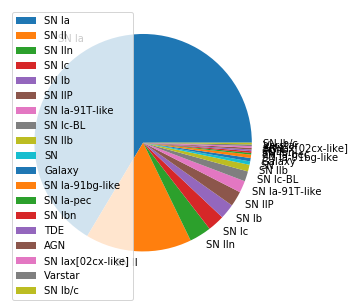

In [21]:
df_SN = all_alerce[classified_mask]["Obj. Type"].value_counts()
print(df_SN)
df_SN.plot.pie(y="count", figsize=(5, 5))
plt.axis("off")
plt.legend()

In [22]:
all_alerce.loc[classified_mask][(all_alerce[classified_mask]["Obj. Type"] == 'SN IIb')]

,ID,Name,RA,DEC,Obj. Type,Redshift,Host Name,Host Redshift,Reporting Group/s,Discovery Data Source/s,...,TNS AT,Public,End Prop. Period,Discovery Mag/Flux,Discovery Filter,Discovery Date (UT),Sender,Remarks,Ext. catalog/s,url
356,56875,SN 2020fqv,12:36:33.260,+11:13:53.87,SN IIb,0.007522,NGC 4568,0.007522,"ALeRCE, ZTF, ATLAS, Pan-STARRS1, YSE, GaiaAlerts","ZTF, ATLAS, Pan-STARRS1, GaiaAlerts",...,1,1,NaN,19.0237,g-ZTF,2020-03-31 08:06:55.002,ALeRCE,NaN,NaN,http://alerce.online/object/ZTF20aatzhhl
280,49753,SN 2019xct,00:38:50.125,-08:19:04.40,SN IIb,0.030000,SDSS J003849.83-081859.1,0.029000,"ALeRCE, ATLAS, ZTF","ZTF, ATLAS",...,1,1,NaN,18.7863,g-ZTF,2019-12-19 03:01:22.000,ALeRCE,NaN,NaN,http://alerce.online/object/ZTF19aczmnqy
313,49720,SN 2019xbm,13:07:14.000,+58:08:03.33,SN IIb,0.026000,UGC 08205,0.027713,"ALeRCE, ZTF, Pan-STARRS1","ZTF, Pan-STARRS1",...,1,1,NaN,19.5441,g-ZTF,2019-12-19 13:22:25.000,ALeRCE,NaN,NaN,http://alerce.online/object/ZTF19acyjjni
246,44660,SN 2019pqo,15:41:30.333,+15:47:03.30,SN IIb,0.014130,NGC 5980,0.013649,"ALeRCE, ATLAS","ZTF, ATLAS",...,1,1,NaN,18.6697,r-ZTF,2019-09-07 05:05:53.000,ALeRCE,NaN,NaN,http://alerce.online/object/ZTF19abxqppy


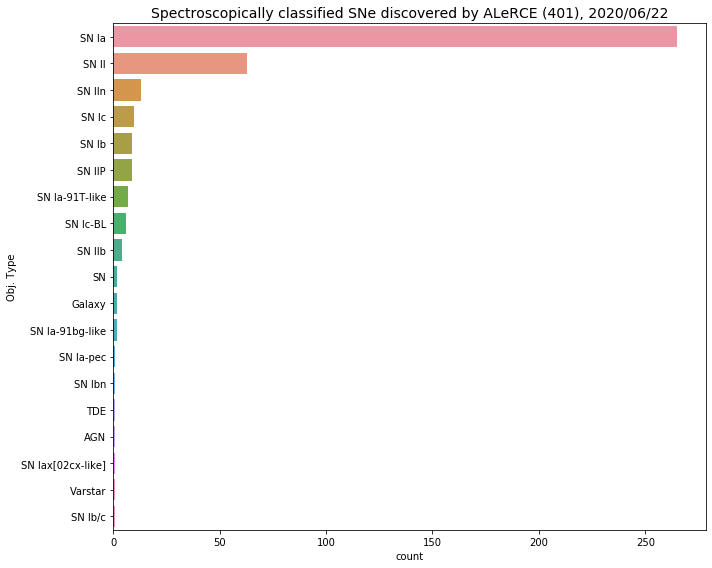

In [23]:
fig, ax = plt.subplots(figsize=(10, 8))
#sns.set(style="darkgrid")
counts = all_alerce[classified_mask]["Obj. Type"].value_counts()
sns.countplot(ax=ax, y="Obj. Type", data=all_alerce[classified_mask], order=counts.index)#cl[n.argsort()[::-1]])
ax.set_title("Spectroscopically classified SNe discovered by ALeRCE (%i), %s/%02i/%02i" % 
             (classified_mask.sum(), now.year, now.month, now.day), fontsize=14)
#ax.axvline(2.5, c = 'gray')
plt.tight_layout()
plt.savefig("plots/SN_types.png")

In [24]:
classified_oids = all_alerce[classified_mask]["Disc. Internal Name"].tolist()

In [25]:
oids = [oid for oid in sent if oid not in retracted]
oids = np.array(oids, dtype = str)

# Optional, use all SNe found, not just those in TNS

In [26]:
mode="tns" #'tns' 'all'
if mode == "all":
    oids = []
    for file in os.listdir("candidates"):
        if file[-3:] == 'txt':
            for oid in open("candidates/%s" % file, 'r').readlines():
                oids.append(oid[:-1])
    oids = np.array(oids)
    oids = np.unique(oids)
    oids = [oid for oid in oids if oid not in retracted]
    oids = np.array(oids, dtype = str)
elif mode=="tns":
    oids = [oid for oid in sent if oid not in retracted]
    oids = np.array(oids, dtype = str)

# Run all these cells if you want to update the results

In [27]:
alerce = AlerceAPI()

In [28]:
import json
credentials_file = "../usecases/alercereaduser_v2.json"
with open(credentials_file) as jsonfile:
    params = json.load(jsonfile)["params"]

In [29]:
conn = psycopg2.connect(dbname=params['dbname'], user=params['user'], host=params['host'], password=params['password'])

In [30]:
query = "select tablename from pg_tables where schemaname='public';"
tables = pd.read_sql_query(query, conn)
tables.sort_values(by="tablename")

,tablename
9,asassn
18,class
10,crtsnorth
12,crtssouth
4,detections
23,early_classification_v2
16,features
22,features_v2
2,features_v3
24,ingestion_timestamp


In [31]:
alltabs = []
for tab in sorted(tables.tablename):
    cols = pd.DataFrame()
    query = "select column_name, data_type from information_schema.columns where table_name = '%s';" % tab
    results = pd.read_sql_query(query, conn)
    results["table"] = tab
    alltabs.append(results)
dftab = pd.concat(alltabs)
pd.options.display.max_rows = 999
display(dftab[["table", "column_name", "data_type"]])
pd.options.display.max_rows = 101

,table,column_name,data_type
0,asassn,ASAS-SN Name,text
1,asassn,Other Names,text
2,asassn,LCID,integer
3,asassn,ra,double precision
4,asassn,dec,double precision
5,asassn,Mean VMag,double precision
6,asassn,Amplitude,double precision
7,asassn,Period,double precision
8,asassn,Type,text
9,asassn,Url,text


In [32]:
query='''
select objects.oid, objects.firstmjd, objects.nobs, objects.meanra, objects.meandec
from objects
where objects.oid in (%s)
''' % ",".join(["'%s'" % oid for oid in oids])
SNe = pd.read_sql_query(query, conn)
SNe.set_index('oid', inplace=True)
SNe.head()

,firstmjd,nobs,meanra,meandec
oid,,,,
ZTF17aaaeqnb,58778.136979,1,19.895777,32.180523
ZTF17aabbxwa,58726.502940,14,80.039296,-17.944241
ZTF17aacqdhh,58846.554456,1,195.458248,43.968051
ZTF17aaddzyk,58803.209572,1,9.765071,-18.608218
ZTF18aaavffc,58789.514595,70,187.979815,32.544523


In [33]:
query='''
select oid, candid, mjd, fid, magpsf, sigmapsf, magpsf_corr, sigmapsf_corr
from detections
where detections.oid in (%s)
''' % ",".join(["'%s'" % oid for oid in oids])
all_detections = pd.read_sql_query(query, conn)
all_detections.set_index('candid', inplace=True)
all_detections.head()

,oid,mjd,fid,magpsf,sigmapsf,magpsf_corr,sigmapsf_corr
candid,,,,,,,
936169913315015012,ZTF19abiijfy,58690.169919,2,19.698338,0.136072,19.698338,0.136072
937371221415015020,ZTF19abiovio,58691.371227,2,20.146393,0.212616,19.115045,0.108332
936168984315015017,ZTF19abiiitl,58690.168981,2,19.884129,0.157709,19.884129,0.157709
936192433315015010,ZTF19abiijfy,58690.192431,1,19.795248,0.122960,19.795248,0.122960
937419020215015009,ZTF19abizkzh,58691.419028,2,20.113478,0.189476,20.113478,0.189476


In [34]:
query='''
select oid, fid, diffmaglim, mjd
from non_detections
where non_detections.oid in (%s)
''' % ",".join(["'%s'" % oid for oid in oids])
all_non_detections = pd.read_sql_query(query, conn)
all_non_detections.set_index('mjd', inplace=True)
all_non_detections.head()

,oid,fid,diffmaglim
mjd,,,
58661.191424,ZTF19abiiitl,2,20.485901
58660.232801,ZTF19abiijfy,2,20.829399
58663.190648,ZTF19abiijfy,2,20.358101
58663.211806,ZTF19abiijfy,1,20.739300
58666.171516,ZTF19abiijfy,2,19.855000


# Histogram of cadences

In [35]:
dts = []
dts_1st = []
dts_fid = []
for oid in all_detections.oid.unique():
    mask = (all_detections.oid == oid)
    times = np.sort(np.array(all_detections.loc[mask].mjd.unique()))
    if mask.sum() > 1:
        dts.append(times[1:] - times[:-1])
        dts_1st.append([times[1] - times[0]])
    for fid in [1, 2]:
        mask = (all_detections.oid == oid) & (all_detections.fid == fid)
        times = np.sort(np.array(all_detections.loc[mask].mjd.unique()))
        if mask.sum() > 1:
            dts_fid.append(times[1:] - times[:-1])
dts = np.concatenate(dts)
dts_1st = np.concatenate(dts_1st)
dts_fid = np.concatenate(dts_fid)

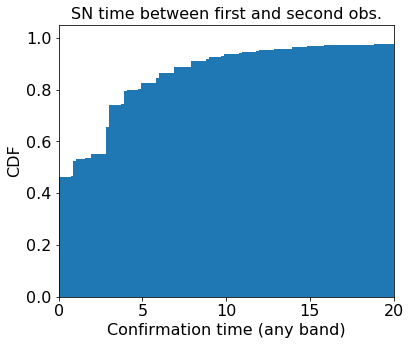

In [36]:
fig, ax = plt.subplots(figsize=(6,5))
ax.hist(dts_1st, bins=1000, cumulative=True, density=True);
ax.set_xlim(0, 20)
ax.set_xlabel("Confirmation time (any band)", fontsize=16)
ax.set_ylabel("CDF", fontsize=16)
ax.set_title("SN time between first and second obs.", fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
plt.savefig("plots/SNconfirmation_any_%s.png" % mode)

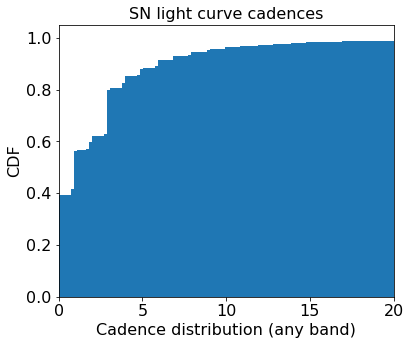

In [37]:
fig, ax = plt.subplots(figsize=(6,5))
ax.hist(dts, bins=1000, cumulative=True, density=True);
ax.set_xlim(0, 20)
ax.set_xlabel("Cadence distribution (any band)", fontsize=16)
ax.set_ylabel("CDF", fontsize=16)
ax.set_title("SN light curve cadences", fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
plt.savefig("plots/SNcadence_any_%s.png" % mode)

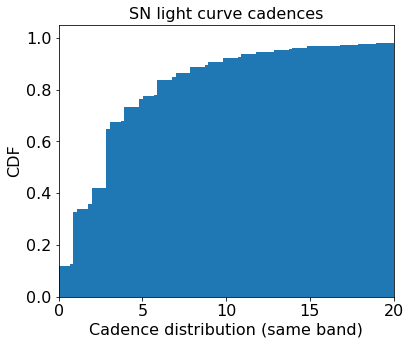

In [38]:
fig, ax = plt.subplots(figsize=(6,5))
ax.hist(dts_fid, bins=1000, cumulative=True, density=True);
ax.set_xlim(0, 20)
ax.set_xlabel("Cadence distribution (same band)", fontsize=16)
ax.set_ylabel("CDF", fontsize=16)
ax.set_title("SN light curve cadences", fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
plt.savefig("plots/SNcadence_same_%s.png" % mode)

# Extract relevant features

In [39]:
nobs = []
dts = []
dt2s = []
dmags = []
dts_fid = []
dmags_fid = []
dmdt_fid = []
first_mjds = []
first_det_mags = []
max_mags = []
max_mjds = []
dt_first_max = []
dmag_first_max = []
ras = []; decs = []
reporting_date = []
reporting_time = []

ids_to_drop = []

for SN in oids:#["ZTF19abpsana"]:
    if SN in SNe.index:
        stats = SNe.loc[SN]
    else:
        print("#### skipping SN ####")
        ids_to_drop.append(SN)
        continue
    stats.dropna(inplace=True)
    detections = all_detections[all_detections.oid == SN]
    non_detections = all_non_detections[all_non_detections.oid == SN]
    try:
        nobs.append(int(stats.nobs))
    except:
        print("#### no stats ####")
        print(stats)
        ids_to_drop.append(SN)
        continue
    
    first_det_idx = detections.mjd.idxmin()
    first_det_mjd = float(detections.loc[first_det_idx].mjd)
    first_det_fid = int(detections.loc[first_det_idx].fid)
    first_det_mag = float(detections.loc[first_det_idx].magpsf)
    first_det_mags.append(first_det_mag)
    ras.append(stats.meanra)
    decs.append(stats.meandec)
    first_mjds.append(first_det_mjd)
    max_mjds.append(detections.loc[detections.magpsf.idxmin()].mjd)
    max_mags.append(detections.loc[detections.magpsf.idxmin()].magpsf)
    dt_first_max.append(max_mjds[-1] - first_mjds[-1])
    dmag_first_max.append(first_det_mags[-1] - max_mags[-1])
    
    mask = non_detections.index < first_det_mjd
    if np.sum(mask) > 0:
        last_non_det_mjd = np.array(non_detections.index[mask]).max()
        last_non_det_mag = non_detections.loc[last_non_det_mjd].diffmaglim
        if last_non_det_mag.shape != ():
            last_non_det_mag = last_non_det_mag.unique()[0]
        dts.append(first_det_mjd - last_non_det_mjd)
        dmags.append(last_non_det_mag - first_det_mag)
    else:
        dts.append(None)
        dmags.append(None)

    mask = (non_detections.index < first_det_mjd) & (non_detections.fid == first_det_fid)
    if np.sum(mask) > 0:
        last_non_det_fid_mjd = non_detections.index[mask].max()
        last_non_det_fid_mag = non_detections.loc[last_non_det_fid_mjd].diffmaglim
        if last_non_det_fid_mag.shape != ():
            last_non_det_fid_mag = last_non_det_fid_mag.unique()[0]
        dts_fid.append(first_det_mjd - last_non_det_fid_mjd)
        dmags_fid.append(last_non_det_fid_mag - first_det_mag)
        dmdt_fid.append(dmags_fid[-1] / dts_fid[-1])
    else:
        dts_fid.append(None)
        dmags_fid.append(None)
        dmdt_fid.append(None)
    
    if nobs[-1] > 1:
        second_det_mjd = detections.mjd[detections.mjd > first_det_mjd].min()
        dt2s.append(second_det_mjd - last_non_det_mjd)
    else: 
        dt2s.append(None)
        
    print(SN, nobs[-1], dts[-1], dt2s[-1], dmags[-1], dmags_fid[-1], dt_first_max[-1])
    

/home/rodrigo/anaconda3/envs/tf1/lib/python3.7/site-packages/pandas/core/series.py:4494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(result)


ZTF20abgvfrf 1 2.9879398000994115 None 0.17504501342769885 0.35804557800290127 0.0
ZTF20abgvuau 1 2.9997106000955682 None 0.45831298828129974 0.45831298828129974 0.0
ZTF20abgvfeh 2 2.9793287001011777 2.9993864998032223 0.07565689086909799 0.18915748596189985 0.0
ZTF20abgvhxc 1 2.9874653002043488 None 0.5539226531981996 0.8088226318358984 0.0
ZTF20abgelig 2 2.042662100197049 2.051770900194242 0.6059970855712002 0.852598190307603 0.009108799997193273
ZTF20abgverg 1 2.9793287001011777 None -0.2724800109862997 -0.23418045043939983 0.0
ZTF20abgrvgp 2 0.09869220020482317 2.0736110998041113 0.11721420288089845 0.26181411743169747 1.9749188995992881
ZTF20abgtvhl 1 None None None None 0.0
ZTF20abgtwby 1 None None None None 0.0
ZTF20abbauvp 1 None None None None 0.0
ZTF20abgtxsn 1 3.151840299993637 None 0.04440307617190342 0.19130325317380326 0.0
ZTF20abguaip 1 3.154305600000953 None 0.8022956848144993 -0.18350410461420097 0.0
ZTF20abgtvkz 1 None None None None 0.0
ZTF20abaserm 1 None None None 

ZTF20abejlzt 8 5.948900400006096 5.981805499905022 -0.876899719238299 -1.0331993103026988 6.031736100099806
ZTF20abekhef 8 2.933900500102027 2.9561920998967253 -0.594244003295902 -0.594244003295902 8.961203699895123
ZTF20abeieul 8 0.02135419999831356 0.9972337997969589 0.15030097961430045 -0.32810020446769883 0.9758795997986454
ZTF20abeojyq 5 2.942615699801536 5.959247699800471 -0.0015792846680007244 -0.0015792846680007244 6.003379600100743
ZTF20abeolsw 8 2.9502777999005048 2.987442100100452 0.6728382110596023 0.6728382110596023 9.030185200295819
ZTF20abeikpu 7 5.931701400098973 5.963657399799558 -0.5639533996581996 -0.8751525878906001 9.032858800099348
ZTF20abejvpr 11 2.988067100101034 3.028622700199776 -0.05270004272460227 -0.4843997955322017 10.023287000098207
ZTF20abepxuj 2 3.0217014000954805 3.028518599901872 -0.36081886291509946 -0.36081886291509946 0.006817199806391727
ZTF20abeqwjn 9 0.015798599801200908 0.9700578998963465 0.11140060424800069 -0.4547004699706996 8.96739590029756

ZTF20abbupkb 13 2.9359027997998055 2.9654050999015453 1.1349029541016016 1.2130031585693999 12.020763799999258
ZTF20abcogax 4 0.9786110998975346 1.0706481000961503 0.11289978027339842 -0.16180038452150214 1.0683564999999362
ZTF20abcofbh 1 1.064328700202168 None 0.264478683471701 0.264478683471701 0.0
ZTF20abcolkd 23 0.0023494997949455865 2.94798609999998 0.28964805603019883 0.28964805603019883 6.8929282003009575
ZTF20abcoodc 4 1.085416699803318 2.108148200000869 0.44265365600589845 0.44265365600589845 3.9683912000982673
ZTF20abchxtq 2 None 0.1526158000997384 None None 0.058391199898323976
ZTF20abbzjrc 1 8.948877300004824 None 1.0157012939453018 1.0157012939453018 0.0
ZTF20abbzosa 2 9.939490699798625 9.999594899898511 0.747468948364201 0.9803695678710014 0.0
ZTF20abbzpry 3 9.938576399901649 9.998657399904914 0.5719318389893004 0.9459323883056996 2.996597200202814
ZTF20abcbfnw 2 0.060104199903435074 9.066458300003433 0.9388599395752024 0.9469604492187997 9.006354100099998
ZTF20abccixp 25

ZTF20aazqtuy 5 5.941597199896933 5.983379599994805 0.055616378784201004 0.055616378784201004 9.044606499897782
ZTF20abailnf 6 5.9410994999998366 5.981956000105129 0.15821456909179688 0.15821456909179688 12.000104200102214
ZTF20abapiwn 13 9.881898099898535 9.968460599797254 -0.5775260925293004 -0.5775260925293004 9.091203700299957
ZTF20abapmiu 3 14.9133565000011 14.978657400002703 0.803764343261701 None 0.0
ZTF20abapvvq 9 13.064757000203826 18.96105330019782 -0.620578765869098 0.271022796630902 11.917268499695638
ZTF20abapyxl 26 0.06563660020037787 3.933240800004569 0.5890998840331996 0.5676994323731002 9.893159699604439
ZTF20abaqucp 1 0.0876735999045195 None -0.09577560424810017 -0.17487716674810017 0.0
ZTF20abascel 4 8.960983799901442 8.987164300095174 -1.6554813385010014 -0.959180831909201 0.02618050019373186
ZTF20aazwnuv 7 8.971551000198815 8.99732640019647 -1.6936645507812003 -1.1804656982422017 0.025775399997655768
ZTF20abasbmn 1 8.972476800103323 None -1.713161468505902 -1.604560

ZTF20aazlwcy 5 3.9513426000994514 4.013101800097502 -0.5276546478270987 -0.4118537902831996 18.01620370009914
ZTF20aazeyrf 3 0.021701400102756452 8.0474884997966 0.21789169311519885 None 0.0
ZTF20aazdfwc 9 0.03688660010084277 7.977071799999976 -0.10885238647459872 0.08024787902830255 8.005844899897056
ZTF20aazjlaa 1 3.0788656999066006 None -1.0307865142822017 -0.4227867126464986 0.0
ZTF20aazihjt 2 3.996724499796983 4.057187499900465 -1.1409988403320988 -1.1409988403320988 0.060463000103482045
ZTF20aazfvxe 2 2.9794097002013586 3.0417591998993885 -2.0642108917235973 -0.9407119750975994 0.06234949969802983
ZTF20aaoxyju 2 5.002048699796433 5.063472299996647 -1.2907009124756001 -0.24049949646000002 0.06142360020021442
ZTF20aazfzmm 6 2.9434144000988454 3.004791700099304 -2.0779972076416016 -1.1103973388672017 11.002210599799582
ZTF20aazgeky 5 2.949108800101385 2.967916699795751 -3.0320186614989986 -2.183517456054698 4.997754599899054
ZTF20aazgirg 5 2.957083400200645 7.96657410019543 -4.46174

ZTF20aawbyds 21 2.9592244999003015 2.983090300200274 0.6555137634277983 0.45881462097169745 7.972407400098746
ZTF20aawcjrx 14 2.95840280019911 2.9921759001954342 0.742893218994201 0.6682929992675994 9.063205999802449
ZTF20aavuyyq 10 0.023865800198109355 3.003240799793275 0.8998088836669993 1.0693092346191975 5.978229099899181
ZTF20aawkfwu 1 0.0376621001996682 None 0.143846511840799 0.2631454467773011 0.0
ZTF20aawkijt 17 0.042661999897973146 2.9868866000979324 0.39261436462409804 0.44941329956060017 8.954675900298753
ZTF20aavxrmh 1 2.9980555001966422 None 0.3383464813233026 0.3383464813233026 0.0
ZTF20aawdjlp 28 2.9756597000014153 3.0163772999003413 0.544141769409201 0.7262420654297017 14.956238499798928
ZTF20aawknzg 17 2.9756597000014153 3.0163772999003413 0.649631500244098 0.8736324310301988 8.935497700200358
ZTF20aawkpvi 13 2.986342600102944 5.944386499904795 0.21568679809569957 0.47008705139160156 6.009039299999131
ZTF20aawbzlo 31 2.9863426000010804 5.932916699799534 1.9088592529296

ZTF20aavqbfo 15 0.048634300103003625 0.06297460020141443 -0.31269836425780184 -0.1951999664306996 9.031111099699046
ZTF20aavpypl 11 6.936932899800013 6.981076400101301 0.49899101257319955 0.49899101257319955 3.017766200006008
ZTF20aavpyxo 26 6.931273200199939 9.92932870020013 0.2544517517089986 0.2544517517089986 9.041759199899388
ZTF20aavqasb 22 7.768460599800164 10.75230319990078 -0.43378639221189985 0.07741355896000002 9.018784800100548
ZTF20aavqcuv 6 7.967905100202188 7.9880092000967124 0.6905345916747976 0.6905345916747976 1.9603587999008596
ZTF20aavramo 20 5.963680600099906 6.027905099799682 0.5082454681397017 0.5082454681397017 2.9768054996966384
ZTF20aaurzyt 5 0.01836810009990586 3.0146759998970083 0.23685073852540128 -0.0771484375 0.0
ZTF20aavrkxw 36 0.8701389000998461 0.9286343002022477 -0.0992679595947017 -0.0992679595947017 13.912268499901984
ZTF20aavrulv 20 5.948877300201275 5.954016199902981 -0.6217002868651988 0.11450004577640271 46.89144669989764
ZTF20aavslbn 15 0.93032

ZTF20aautxwy 34 9.81606479990296 9.842824099803693 -0.7004470825196023 -0.7338466644287998 7.996307900102693
ZTF20aauufjg 9 12.812986099794216 12.854803300193453 -0.2687129974366016 -1.8208141326905007 1.015625
ZTF20aausuzy 16 9.863518499900238 9.895567100196786 -0.9873008728028019 -0.9873008728028019 11.067303200194146
ZTF20aausbfk 17 10.011238400198636 18.007395799999358 -0.9691505432128018 -0.23985099792480113 13.96462959980272
ZTF20aautfgp 5 10.01031250019878 10.054976899897156 -1.2119998931885014 -0.45510101318360086 10.999189799600572
ZTF20aausbfv 2 9.992326400097227 18.974930600197695 -0.8123931884765021 None 0.0
ZTF20aaurxhc 4 10.000300899795548 18.04928240009758 -0.735988616943299 -0.35448837280269885 11.044525500401505
ZTF20aaurxdd 26 14.84785880020354 14.903622700003325 0.241773605346701 0.241773605346701 8.075902799595497
ZTF20aaurzxs 8 9.99701390019618 10.044016199797625 -0.6623249053955007 None 8.01261579990387
ZTF20aausbec 2 9.992326400097227 18.974930600197695 -0.390569

ZTF20aauqtpy 32 28.970555600200896 28.994039299803262 -3.1029548645019993 -3.4667549133300994 10.959536999900592
ZTF20aauqtcp 15 3.9776504002002184 4.0139582999036065 -1.5639467239380025 2.3344535827636967 0.0363078997033881
ZTF20aauqhka 34 0.060115699903690256 9.87759260020539 0.3507308959960014 1.3262310028075994 10.857650500300224
ZTF20aauqnar 23 26.923877399793128 26.936192199995276 -2.5306549072266016 -2.5306549072266016 0.0
ZTF18aajivpr 26 4.984351899802277 14.876203699903272 -0.33394241333009944 -0.33394241333009944 11.94063650030148
ZTF20aauqdhi 1 4.973194500002137 None 1.3405590057372976 1.3405590057372976 0.0
ZTF20aaupkul 8 3.9893982002031407 3.9929050999999163 -1.9588394165038991 -1.9588394165038991 11.006805500001065
ZTF20aaupkac 4 4.001597199894604 15.012025399897539 2.190402984619098 2.8754024505614986 11.010428200002934
ZTF20aaupbuq 1 3.9534605998996994 None -4.289192199706999 -4.289192199706999 0.0
ZTF20aauovyw 1 0.01951390020258259 None 0.033323287963799686 0.033323287

ZTF20aatuyrz 2 20.94809030019678 20.986932899999374 0.00040054321289773043 -1.7566986083985014 0.038842599802592304
ZTF20aatuocq 1 0.03914349989645416 None 1.4936008453368999 0.719100952148402 0.0
ZTF20aatupwl 33 20.955648199800635 20.985034700206597 0.6387348175049006 -0.07006645202639916 5.009421300099348
ZTF20aatupsp 2 20.955648199800635 20.985034700206597 0.20477485656740058 -0.540325164794897 0.02938650040596258
ZTF20aatuyut 10 19.101053300197236 19.13374999989901 -4.657900810241701 -4.657900810241701 4.029062499801512
ZTF20aatuprg 1 19.101956100101233 None -3.8239192962645987 -3.8239192962645987 0.0
ZTF20aatuqdp 1 19.101053300197236 None -4.2926483154297 -4.2926483154297 0.0
ZTF20aatuqfl 20 20.957500000004075 20.990208399904077 -0.45511054992680045 -4.354711532592798 16.96261580009741
ZTF20aatphce 3 23.026435200205015 25.937708300203667 0.22788429260249998 0.30158424377439985 2.9112730999986525
ZTF20aasspap 3 24.00098380020063 26.947766200100887 -0.2708396911620987 -0.27083969116

ZTF20aatpxda 4 20.83472219989926 20.952048600200214 -0.17660522460939987 -0.17660522460939987 0.0
ZTF20aatvdpj 7 20.785092600002827 20.93031250020431 -0.4126014709472017 -0.9154014587402024 7.116192100096669
ZTF18aazhjzt 2 20.84543980019953 20.98228009990271 -0.6450004577636008 -0.6450004577636008 0.1368402997031808
ZTF20aatpspm 14 18.87520839980425 18.97895840000274 -2.0294113159178977 -0.12111091613769887 8.086550900196016
ZTF20aatpwxy 2 21.79706010009977 21.926550899799622 0.20096206665040128 -0.3655376434325994 0.12949079969985178
ZTF20aatqgsf 4 21.798483799997484 22.88031249999767 1.1520175933837997 0.6819171905518004 0.0
ZTF20aatpxro 2 21.833356499999354 22.919305600102234 -0.1941490173338991 -0.1941490173338991 0.0
ZTF20aatqiao 27 21.83289349990082 21.940138900004968 -0.11649703979490056 -0.11649703979490056 8.0505786999056
ZTF20aatqbmw 23 21.83289349990082 21.940138900004968 0.7463760375976989 0.7463760375976989 8.0505786999056
ZTF20aatqicp 3 21.83424770020065 22.91468750010244

ZTF20aascwar 39 0.021527800199692138 0.030578699901525397 0.33440208435060015 0.33440208435060015 24.92711799959943
ZTF20aascypf 1 0.021469900202646386 None -0.2197170257568004 -0.1095161437987997 0.0
ZTF20aasacjv 1 0.02265049979905598 None 0.15535545349129976 0.15535545349129976 0.0
ZTF20aabqfpl 1 0.014189800196618307 None 0.2380828857422017 0.2380828857422017 0.0
ZTF20aartywi 6 2.9780901998019544 5.980034699801763 -0.6081466674804972 0.19075393676749997 3.0402777999988757
ZTF20aarqqdz 7 3.8767360998972435 3.9780556000987417 0.07037544250490058 0.14487457275389914 3.062245400098618
ZTF20aarzomh 3 4.940578700101469 5.020011600099679 0.6182003021240021 0.6182003021240021 2.994178299799387
ZTF20aaruqnd 1 0.03730329990503378 None 2.4565544128418004 2.4565544128418004 0.0
ZTF20aartnkv 40 1.858148100101971 2.0071180000013555 -0.6514987945556001 0.042301177978501414 30.999687499897846
ZTF20aarzsgh 1 0.04018519990495406 None 0.05711364746089842 0.09671401977540128 0.0
ZTF20aardijr 1 0.9379050

ZTF20aanvqbi 42 3.981666699895868 7.97633100009989 -0.3128547668456996 0.5741462707518998 16.953888900105085
ZTF20aanvpzo 16 3.981666699895868 7.97633100009989 0.9633388519287003 1.7875385284424006 8.998888900001475
ZTF20aanvvmv 10 1.0027083999011666 1.0321990999000263 0.5023002624512003 0.5023002624512003 3.9957754002025467
ZTF20aanvswj 3 8.996365699997114 9.013911999900301 0.9711837768555007 0.9711837768555007 0.0
ZTF20aamzizz 14 0.02237270009936765 0.04989590009790845 0.0697994232177983 0.0697994232177983 0.0
ZTF20aanlauv 1 0.06105329990532482 None 0.3481254577637003 0.4187259674072017 0.0
ZTF20aanhmnw 1 0.047013900097226724 None 0.453762054443299 0.453762054443299 0.0
ZTF20aanhenj 17 0.9479977000009967 1.0787499998987187 -0.5128078460693999 -0.39770889282230115 11.200023100194812
ZTF20aanfdez 22 0.054594899898802396 0.055509299905679654 0.3251609802245987 -0.18553924560550072 12.926354200106289
ZTF20aandnyk 1 0.9742593000046327 None -0.38715553283689985 -0.6320571899414027 0.0
ZTF2

ZTF20aalbtwh 13 0.9890740999035188 1.0452893000037875 -0.8563003540038991 -0.8563003540038991 14.02697910000279
ZTF18adcdcrd 28 0.9135301001006155 2.937245400098618 0.3351039886475 0.3983039855956996 14.004849499993725
ZTF20aakwcfh 43 0.908599599802983 1.9468056002006051 0.36434745788579903 -0.08755302429199929 11.044317100197077
ZTF20aakzdwl 1 2.9584954000019934 None 0.5125293731689986 0.703729629516598 0.0
ZTF20aaknyfo 1 0.0009027999039972201 None 0.2446575164794993 0.2446575164794993 0.0
ZTF20aakoenh 2 1.953206099999079 1.9962962999998126 0.3584995269775 0.46249961853019883 0.0430902000007336
ZTF20aakocfl 7 0.9775693997944472 0.9809490999978152 -0.03499221801759944 -0.03499221801759944 2.0049074003036367
ZTF20aakmbql 1 0.029479199896741193 None -0.241279602050799 0.31842041015629974 0.0
ZTF20aaknzsj 1 1.953206099999079 None 1.2425289154053019 1.3465290069580007 0.0
ZTF20aakodiq 56 2.985844900205848 3.003182799802744 0.22384643554689987 0.5538463592529013 14.95972219989926
ZTF20aakfh

ZTF19aambkao 4 10.899444400100037 11.0215509000991 -0.44628524780269885 -0.7405853271483984 1.0779281998984516
ZTF20aahgkhg 15 7.939861099999689 7.940312499900756 -0.6243705749512003 -0.10057067871090197 6.082025499999872
ZTF20aahrwoc 2 15.895752299802552 16.001840300203185 0.4102001190185014 0.4102001190185014 0.10608800040063215
ZTF20aahpxzz 16 8.998333299903607 9.123657400101365 0.7350673675537003 0.7350673675537003 9.06850700029463
ZTF18aawiulg 4 7.91710650009918 8.050034700099786 0.6893863677978018 0.2432861328125 1.1185647999009234
ZTF20aagmpdc 22 9.939606499901856 10.059432900103275 0.38993835449210223 0.38993835449210223 6.119027799897594
ZTF20aahpith 1 0.9221758999992744 None 2.688270568847699 2.374271392822301 0.0
ZTF20aahmiwt 1 0.0735416997995344 None 1.8813304901123011 1.6909313201904013 0.0
ZTF20aahlizy 3 10.978009300204576 13.934224500204436 -0.9712162017821981 -0.9712162017821981 2.9562151999998605
ZTF20aahjzwq 9 4.849062500099535 4.911597299898858 0.6680431365966975 0.6

ZTF20aaftsqt 23 4.086712999902375 8.995613400096772 -0.23400688171380324 -0.23400688171380324 8.904270800296217
ZTF20aafzfjy 1 0.02865739980188664 None -0.03818893432610082 -0.8512878417968004 0.0
ZTF20aafytzs 2 0.026713000203017145 0.027176000199688133 0.4438629150391016 -1.7750377655028977 0.00046299999667098746
ZTF20aafyodo 3 0.023402799997711554 35.1146875002014 0.3375320434569993 -0.26486778259280186 45.08645830020396
ZTF20aageyxs 8 3.9624537001000135 4.04464119990007 -0.7757949829102024 -0.7757949829102024 3.0784144001008826
ZTF20aagiiik 4 2.980416599799355 3.0295022997961496 -1.0202007293702025 -1.0202007293702025 12.087939900397032
ZTF20aaghodz 6 4.062569499903475 12.91884260020015 -0.4979496002197017 1.1442508697509979 8.856273100296676
ZTF20aagfgbp 9 2.912083299801452 5.941516200102342 -0.4016571044922017 -0.6126575469971023 7.003958400404372
ZTF20aafksjo 4 2.912071799801197 9.934247700002743 -1.185764312744201 -1.424863815307603 7.046307899996464
ZTF20aaghiif 4 0.08215280009

ZTF20aaertpj 22 3.0310995998006547 3.0474652998018428 0.8981113433837997 0.8981113433837997 16.00008100040577
ZTF20aaertil 18 3.0310995998006547 3.0474652998018428 0.7315158843993999 0.7315158843993999 6.895763900203747
ZTF20aaerrhb 1 1.0518171001021983 None 0.30675888061519885 0.30675888061519885 0.0
ZTF20aaerqbx 6 3.0134838002049946 3.0319907001030515 0.8968105316162003 0.8968105316162003 0.0
ZTF20aaerpoj 6 3.008044000103837 5.959143500098435 0.382818222045902 0.382818222045902 2.951099499994598
ZTF20aaervyn 13 3.0071412000979763 3.0260880001005717 -0.3289012908935014 -0.3289012908935014 16.01464119979937
ZTF20aaervoa 6 3.0071412000979763 3.0260880001005717 -0.3757991790771982 -0.3757991790771982 0.01894680000259541
ZTF18acydrro 1 3.0374306001031073 None 0.9944534301758026 0.9944534301758026 0.0
ZTF20aaeqxtc 6 2.8975578001045506 6.894953700204496 1.2985935211181001 0.43809318542480113 6.982777799894393
ZTF20aaeqmjl 5 2.874444399996719 8.907476800100994 1.2022037506104013 0.0643043518

ZTF20aabqvvw 5 11.953391200004262 11.992349600004673 -2.1067008972168004 -2.1067008972168004 0.03895840000041062
ZTF20aabqilc 7 13.993692200194346 14.040266199997859 0.16799163818360086 0.16799163818360086 0.0
ZTF20aabqiiy 19 13.944999999803258 13.99247679990367 0.22940635681149857 -0.13979339599610086 10.981412000001
ZTF20aabqimd 2 11.952476899896283 14.999247699801344 -1.9233474731444993 -1.9233474731444993 0.0
ZTF20aabqiav 31 13.99097219989926 14.041608800194808 1.4759368896485014 1.4759368896485014 10.99674770009733
ZTF20aabqibc 4 13.99097219989926 14.041608800194808 0.014093399047801825 0.014093399047801825 0.050636600295547396
ZTF20aabqhpy 15 12.956724600000598 13.013680600102816 0.2732868194580007 None 0.05695600010221824
ZTF20aabqhhr 8 13.98598380000476 14.043854200201167 0.3295822143553977 0.3295822143553977 0.05787040019640699
ZTF20aabqhfp 3 19.93736119980167 19.976689900198835 -0.06066322326660156 None 0.0
ZTF20aabqbxm 16 11.921053300204221 11.978622700102278 -0.681058883666

ZTF19adbmftz 7 6.9923033000013675 7.003645799901278 -1.5150356292725 -1.5150356292725 6.053749999999127
ZTF19adbmeva 8 7.968958399898838 12.02874999980122 -0.2179946899414027 -0.2179946899414027 7.043472200202814
ZTF19adbmdxy 1 7.9685185000053025 None -0.8822441101074006 -0.8822441101074006 0.0
ZTF19adbmdnz 3 7.967175899895665 8.01582169989706 -0.5291042327881001 -0.5291042327881001 3.05314810010168
ZTF19adbmdsa 10 7.967175899895665 8.01582169989706 -0.4033966064454013 -0.4033966064454013 9.108506900200155
ZTF19adbfhal 7 5.018900399903941 17.004363399806607 0.42673492431639914 0.5416355133056996 0.0
ZTF19adbewtd 1 0.04384260000369977 None -0.4941215515137003 1.8180770874023011 0.0
ZTF19adazgzy 1 0.0023611000942764804 None 0.47829627990719814 0.47829627990719814 0.0
ZTF19adaymon 1 1.0252199000969995 None 0.016508102417002846 0.016508102417002846 0.0
ZTF19adaylfn 1 2.9749305001969333 None 0.19374656677240054 -0.4125518798827983 0.0
ZTF19adaykkr 1 2.970405100102653 None -0.508474349975600

ZTF19acynhrc 4 3.96195599980274 4.001492999806942 -2.373100280761701 -0.9649009704590021 0.03953700000420213
ZTF19acyngrm 1 3.8782638998964103 None -1.5170516967774006 -1.5170516967774006 0.0
ZTF19acykkoh 1 1.9881944999942789 None -0.5584259033204013 -0.427925109863299 0.0
ZTF19acyndsy 8 None 6.391875000095752 None None 3.92326389990194
ZTF19acyndsh 10 None 7.411412000095879 None None 0.0
ZTF19acymzwh 42 None 6.389155099997879 None None 6.923321799804398
ZTF19acyndrl 4 None 8.446122699795524 None None 0.0
ZTF19acyndpl 17 None 21.401041699995403 None None 18.99539350019768
ZTF19acxqaot 43 None 23.418182900095417 None None 30.013194399900385
ZTF19acyncwv 1 0.00046300009853439406 None -0.04940986633300071 -0.04940986633300071 0.0
ZTF19acynclu 1 0.10297450009966269 None -0.27009201049810017 -0.05029296875 0.0
ZTF19acyncyx 24 3.008159799799614 3.0231365998042747 0.10459899902350145 0.10459899902350145 0.11637730020447634
ZTF19acyksfd 21 2.97901619989716 2.9983912000025157 -0.711257934570298

ZTF19acvgdio 9 5.916898199997377 30.87636570000177 0.07348442077630324 -1.5525150299072976 50.936284700001124
ZTF19acvgcrp 1 7.934861099995032 None -0.38736152648920097 -0.0026626586913991446 0.0
ZTF19acvgcvc 4 7.934861099995032 7.963715300196782 -0.030069351196303273 0.22323036193849788 18.980752300005406
ZTF19acvgbqr 2 5.966713000001619 5.998298599799455 0.05554580688480115 0.05554580688480115 0.03158559979783604
ZTF19acvfvjt 1 7.036331000097562 None -0.09986877441409803 -0.09986877441409803 0.0
ZTF19acvfryu 7 7.001666599899181 7.002117999800248 0.6387443542480007 0.7065448760986008 8.046666699898196
ZTF19acvfmnq 2 6.916574100199796 6.953043999797956 -0.7213783264160014 -0.4117774963379013 0.03646989959815983
ZTF19acudlxq 6 6.001620400100364 6.998715300003823 0.5270061492919993 0.5270061492919993 0.997094899903459
ZTF19acudiph 12 5.999513900103921 6.000416599905293 1.0780792236327983 1.0780792236327983 17.98348379969684
ZTF19acudgtb 2 8.0130670997969 11.019664300198201 -3.17680168151

ZTF19acrdcwh 4 2.9798495998984436 8.024687499797437 -0.265428543090799 -0.265428543090799 14.962407400300435
ZTF19acrcmvw 4 0.9310879998010932 7.954814799799351 -0.07631111145019887 0.5674877166748011 14.047430500402697
ZTF19acqzsdo 1 3.9271990999986883 None 0.5953960418700994 0.5953960418700994 0.0
ZTF19acrbyzj 27 3.0281480999983614 5.95918979979615 1.5321369171143004 1.5321369171143004 9.933830999798374
ZTF19acrbzau 3 7.005833300099766 40.913449100000435 0.20592880249029832 0.20592880249029832 33.90761579990067
ZTF19acqyvbu 1 0.06127310010197107 None -0.636198043823299 0.4579010009765021 0.0
ZTF19acqxoll 22 3.0026852000009967 3.0728587998019066 0.240716934204098 0.240716934204098 18.002476899899193
ZTF19acqupbp 7 6.927627300203312 10.857245399900421 0.9980659484862997 0.6509647369385014 3.929618099697109
ZTF19acqssza 1 0.018425899899739306 None 0.3125934600830007 0.3125934600830007 0.0
ZTF19acqrses 2 0.039282399899093434 16.94725700019626 0.18467712402339842 0.6305770874022976 0.0
ZT

ZTF19acmbiad 37 3.9949651997958426 4.025682799998322 -0.7056369781493999 -0.48293685913089845 14.034895900200354
ZTF19acmbgwx 11 0.9952777998987585 3.986493100201187 -0.2859230041504013 0.919677734375 10.03907410010288
ZTF19acmbems 3 3.0016781997983344 6.023298599997361 0.3513698577880007 0.2661705017088991 0.0
ZTF19aclobbu 142 2.01769670000067 2.1018866001977585 1.8406372070312997 2.2433376312256 12.977280099898053
ZTF19aclnmka 1 0.06032410019543022 None 0.2524375915527983 0.6756381988525995 0.0
ZTF19acivqkf 25 6.997615799897176 9.000034799901186 0.20329856872560015 0.2900981903075994 5.014259199997468
ZTF19aclloku 13 2.963576399903104 2.985416699804773 0.577949523925799 0.7894496917725 65.91626160030137
ZTF19acllegk 4 6.975347199804673 8.991481500102964 0.09467315673829901 0.09467315673829901 2.0161343002982903
ZTF19aclklzo 5 1.000902800100448 2.029537000002165 -0.5876026153564027 -0.5876026153564027 0.0
ZTF19ackxfak 1 4.0059259000991005 None 0.9977092742919993 0.910108566284098 0.0


ZTF19acgrbeb 24 4.106446799996775 10.136492999903567 1.2023582458495987 -0.8557415008544993 11.998703700002807
ZTF19achehes 5 6.95376160019805 10.933530099900963 -1.1850185394287003 -1.1275196075438991 3.9797684997029137
ZTF19accvgap 1 0.00045140019938116893 None 0.4924564361572017 0.4924564361572017 0.0
ZTF19achbgzn 1 0.9718982000995311 None 1.0222682952881001 0.9567699432373011 0.0
ZTF19achbchr 9 0.01968749999650754 3.0189120998984436 0.41434860229490056 0.7692470550537003 6.004618099897925
ZTF19achaxps 1 0.02193289999559056 None -0.017457962036100838 0.5072422027587997 0.0
ZTF19achaspq 11 2.9761920999008 6.004282399902877 0.5266075134277983 -3.442192077636701 14.013738499896135
ZTF19achaqju 9 2.9684606001974316 8.926701399803278 0.015830993652301117 0.015830993652301117 11.99479170000268
ZTF19acdlakc 1 0.02635419979924336 None -0.4088230133056996 None 0.0
ZTF19achamsv 11 0.02635419979924336 7.0219212998999865 -0.3462696075439986 None 0.0
ZTF19achammg 7 0.04032410010404419 11.8735879

ZTF19aceqlxc 58 1.0116204000951257 7.047754599894688 0.3334369659424006 0.9189376831055007 24.02574069990078
ZTF19aceqjqw 9 1.019305600093503 17.00626159999956 0.5564670562743999 1.3696670532227024 22.008113400101138
ZTF19aceqbqb 3 1.172812500197324 6.998611100199923 -0.09814071655280188 1.0554599761962997 0.0
ZTF19acennqf 10 4.870868099904328 8.96321759980492 0.7655334472656001 1.3854331970214986 9.132083299999067
ZTF19acenjem 14 0.9996759002024191 3.0010879002002184 -0.04446029663090201 -0.04446029663090201 2.0014119999977993
ZTF19acenhzd 1 0.966666700100177 None 0.4432945251463991 0.21439552307129972 0.0
ZTF19acelcan 13 3.918067099803011 6.994895799805818 0.4104843139648011 1.2794857025146023 17.038298600396956
ZTF19abtfplj 6 0.9705902999994578 39.02788200000214 -0.2350101470947017 -0.31641006469730115 0.0
ZTF19acekrfo 1 3.924525500202435 None -0.1917591094971023 0.7222404479979971 0.0
ZTF19acekret 6 3.9236226997963968 10.900370399802341 -0.39637565612790127 0.5502243041993005 6.976

ZTF19accdebl 4 0.02177079999819398 3.0002314997982467 0.5800666809081996 None 2.9784606998000527
ZTF19acbwilc 11 7.992997699795524 11.001817100201151 1.5895366668700994 1.5895366668700994 0.0
ZTF19acbwiry 7 8.99964119989454 9.000555599894142 0.8078956604003977 0.8078956604003977 9.989490800100612
ZTF19acbwizl 4 9.0162384997966 12.000474600099551 0.7181167602539027 1.0410175323486008 0.0
ZTF19acbwjcs 4 9.0162384997966 12.000474600099551 0.6598281860350994 0.268629074096598 6.98549759999878
ZTF19acbwjip 2 12.996990700099559 15.980335600099352 0.5715026855468999 0.5715026855468999 0.0
ZTF19acbwjjz 13 6.995266200101469 9.974895900195406 -0.1125240325927983 0.21597480773930045 13.985868100098742
ZTF19acbwjue 8 9.0121180001006 11.991273100094986 0.6718120574952025 0.9057121276856002 9.987615799997002
ZTF19acbwkge 4 7.99194439999701 10.971111100101552 0.7083930969237997 0.7083930969237997 0.0
ZTF19acbwmqd 13 8.003449100200669 10.998078699798498 1.4005165100097976 1.4005165100097976 6.05725689

ZTF19acagcjo 5 0.9716204001015285 1.9979629997978918 0.4977092742919993 0.16810798645020242 0.0
ZTF19acarcrv 1 0.9717708001990104 None 0.8703899383544993 0.8095893859862997 0.0
ZTF19acaqyjj 1 6.005416699903435 None 0.34687423706049714 0.34687423706049714 0.0
ZTF19acaqyjp 15 3.00385419990198 13.001226899803441 1.5361156463622976 1.5361156463622976 9.997372699901462
ZTF19acaqyaj 2 12.967986100105918 23.966574100100843 0.2762603759765021 -0.10643959045409801 0.0
ZTF19acantvb 5 5.940914299906581 13.000763900206948 -0.8764209747315022 -0.8764209747315022 10.99312500009546
ZTF19acanlub 1 0.02431709980010055 None 0.06279754638680046 -0.5931015014647976 0.0
ZTF19acanluc 1 2.9239466998988064 None -0.7762737274169993 -0.7762737274169993 0.0
ZTF19acaniow 1 0.023391200200421736 None 0.13238334655759942 -0.5678157806396023 0.0
ZTF19acanhbx 5 0.023391200200421736 8.026793999997608 0.37541198730469816 -0.23398780822759946 8.003402799797186
ZTF19abzyrtp 1 2.9159374999944703 None -0.19462585449219816 -

ZTF19abyxlmu 1 0.9661225997988367 None -0.19147682189939985 -0.11977577209469814 0.0
ZTF19abyzuos 19 3.0037732000055257 6.003136600003927 -0.12459182739259944 0.10690879821780186 15.034664299797441
ZTF19abyxihe 8 0.9669097998994403 2.9684837997992872 -0.4507961273193999 0.16050338745110082 8.001770800001395
ZTF19abxwkty 8 0.9669097998994403 0.9968865999981062 -0.4481086730956996 0.0017910003662002794 0.02997680009866599
ZTF19abywtbb 1 1.0277083000983112 None 0.5630683898925994 0.5630683898925994 0.0
ZTF19abyuzch 25 0.13149310009612236 2.9995255000976613 -0.23779106140140271 0.4894084930419993 13.992164299801516
ZTF18aamubvi 1 0.9703010002049268 None 0.71169090271 1.012090682983402 0.0
ZTF19abytufp 6 2.958807900096872 2.99385419999453 0.5173892974852983 0.5173892974852983 0.03504629989765817
ZTF19abyqytr 1 0.9707639002008364 None 0.648389816284098 0.4888896942137997 0.0
ZTF19abyrajk 1 0.9535764000029303 None 0.8183689117431001 0.7307701110840021 0.0
ZTF19abyqliz 2 6.082731499802321 19.0

ZTF18aaqujyc 1 2.9526505000976613 None 0.7454910278320988 0.7232894897461009 0.0
ZTF18aakjdhr 1 4.000254599995969 None 1.1732654571533025 1.1732654571533025 0.0
ZTF19abvanim 18 2.9658448998015956 2.982870399901003 0.6193046569825 0.5276050567627024 16.998344900101074
ZTF19abvalfd 18 2.9690856000961503 2.979155099899799 2.0853195190430007 2.119319915771502 16.980671300101676
ZTF19abvdbyx 17 2.888935199996922 7.927847200102406 0.852321624755902 -0.04027748107909801 17.095636500002
ZTF19abvakbo 16 1.0219676002016058 3.998703700097394 0.2905464172362997 0.2905464172362997 6.952164399895992
ZTF19abvdgqo 36 0.022824100095022004 2.9761227000999497 1.584833145141598 1.6577320098876989 9.974548599704576
ZTF19abvehtp 3 2.949398200100404 6.0009375001027365 0.0015449523925994413 0.0015449523925994413 3.0515393000023323
ZTF19abvfvrq 3 0.07299770010286011 5.0542476998016355 -0.02188491821289773 0.030616760253899145 8.000995399896055
ZTF19abvgwcs 3 2.9777315000028466 7.95616900009918 -0.1865558624268

ZTF19abrdznp 3 0.012523100100224838 6.011805499801994 0.04305076599120028 0.14444923400879972 6.01606479990005
ZTF19abrdyfn 3 6.86936339980457 15.862245400101529 -0.6352519989012997 -0.6087512969969993 0.0
ZTF19abrdiny 1 0.07104170019738376 None 0.04082298278810015 -0.017875671386700986 0.0
ZTF19abrctbt 9 4.97899299999699 7.945104099897435 -0.2616539001464986 -0.1968536376952983 2.966111099900445
ZTF19abqrxhy 8 2.9575115002007806 9.958009199901426 0.3026332855225 0.3026332855225 7.000497699700645
ZTF19abrcief 4 3.1366434998999466 6.157812500197906 -0.11237525939939985 -0.11237525939939985 0.0
ZTF19abrbpal 2 0.930659700105025 0.9329166999013978 0.5213928222656001 0.5213928222656001 0.0
ZTF19abrbczz 4 0.025821800096309744 5.024664399898029 0.03758811950680041 0.06378746032720173 0.0
ZTF19abqykuc 7 2.9959722002022318 9.01121530020464 -0.34344863891599786 None 27.979525499999
ZTF19abpeciv 5 3.999548599800619 6.979351899797621 -0.243923187255902 -0.243923187255902 2.979803299997002
ZTF19abq

ZTF19abnhkdx 6 6.055046299901733 9.020705999799247 0.6780509948731002 0.6780509948731002 5.984340300303302
ZTF19abnchgq 4 0.018125000002328306 3.0214815001017996 0.5976428985594993 0.5976428985594993 3.0033565000994713
ZTF19abnpvuy 3 2.990335700000287 7.012048600205162 0.3260612487793004 0.3260612487793004 4.021712900204875
ZTF19abnptsy 1 0.028321700199740008 None 1.4777412414550994 1.1343421936034979 0.0
ZTF19abnphxo 2 6.041180500098562 10.03658559989708 -0.6179561614989986 -0.6179561614989986 3.9954050997985178
ZTF19abnozgb 1 2.973993000203336 None 0.06566619873040125 0.18146514892569954 0.0
ZTF19abnpeja 2 5.9433216997931595 12.008449099994323 0.6928272247314986 0.6928272247314986 0.0
ZTF19abnobkg 1 5.992013899900485 None -1.156669616699201 0.8567314147949006 0.0
ZTF19abnmqtw 6 2.025277800101321 3.0288657998971757 -1.2818393707275995 -0.2513389587403019 8.889421299994865
ZTF19abnmwxd 66 1.99627319980209 1.9967708999975002 -4.7307376861572 -4.7307376861572 10.933171300195681
ZTF19abnk

In [40]:
new_oids = []
for oi in oids:
    if oi in ids_to_drop:
        continue
    else:
        new_oids.append(oi)

oids = new_oids

len(oids), len(nobs), len(dts), len(dt2s), len(dmags), len(dts_fid), len(dmags_fid), len(first_mjds), len(dt_first_max)

(3060, 3060, 3060, 3060, 3060, 3060, 3060, 3060, 3060)

In [41]:
df = {'oid': oids, 'nobs': nobs, 'dt': dts, 'dt2': dt2s, 'dmag': dmags, 'dt_fid': dts_fid, 
      'dmag_fid': dmags_fid, 'first_mjd': first_mjds, 'first_det_mag': first_det_mags, 
      'ra': ras, 'dec': decs, 'dt_first_max': dt_first_max, 'dmag_first_max': dmag_first_max,
      'mag_at_max': max_mags, 'dmdt_fid': dmdt_fid}
df = pd.DataFrame(df)
df.head()

,oid,nobs,dt,dt2,dmag,dt_fid,dmag_fid,first_mjd,first_det_mag,ra,dec,dt_first_max,dmag_first_max,mag_at_max,dmdt_fid
0,ZTF20abgvfrf,1,2.987940,NaN,0.175045,7.014445,0.358046,59021.213843,19.976055,182.056513,-0.005535,0.000000,0.000000,19.976055,0.051044
1,ZTF20abgvuau,1,2.999711,NaN,0.458313,2.999711,0.458313,59021.238113,20.124786,198.747794,19.176979,0.000000,0.000000,20.124786,0.152786
2,ZTF20abgvfeh,2,2.979329,2.999386,0.075657,10.010787,0.189157,59021.212431,20.119743,207.919905,-14.672767,0.000000,0.000000,20.119743,0.018895
3,ZTF20abgvhxc,1,2.987465,NaN,0.553923,7.013495,0.808823,59021.214306,19.684378,180.148759,7.792950,0.000000,0.000000,19.684378,0.115324
4,ZTF20abgelig,2,2.042662,2.051771,0.605997,3.024896,0.852598,59021.229479,19.992702,207.189515,18.423204,0.009109,0.001183,19.991520,0.281860


In [42]:
df.to_pickle("alerce_summary_%s.pkl" % mode)

# Start from here if you want to use available results

In [43]:
mode = 'tns' #'tns'
df = pd.read_pickle("alerce_summary_%s.pkl" % mode)
oids = df["oid"].values
df.set_index("oid", inplace=True)
df.head()

,nobs,dt,dt2,dmag,dt_fid,dmag_fid,first_mjd,first_det_mag,ra,dec,dt_first_max,dmag_first_max,mag_at_max,dmdt_fid
oid,,,,,,,,,,,,,,
ZTF20abgvfrf,1,2.987940,NaN,0.175045,7.014445,0.358046,59021.213843,19.976055,182.056513,-0.005535,0.000000,0.000000,19.976055,0.051044
ZTF20abgvuau,1,2.999711,NaN,0.458313,2.999711,0.458313,59021.238113,20.124786,198.747794,19.176979,0.000000,0.000000,20.124786,0.152786
ZTF20abgvfeh,2,2.979329,2.999386,0.075657,10.010787,0.189157,59021.212431,20.119743,207.919905,-14.672767,0.000000,0.000000,20.119743,0.018895
ZTF20abgvhxc,1,2.987465,NaN,0.553923,7.013495,0.808823,59021.214306,19.684378,180.148759,7.792950,0.000000,0.000000,19.684378,0.115324
ZTF20abgelig,2,2.042662,2.051771,0.605997,3.024896,0.852598,59021.229479,19.992702,207.189515,18.423204,0.009109,0.001183,19.991520,0.281860


### Histogram of UT times of first detection

In [44]:
df["first_UT"] = df.apply(lambda row: float(Time(row["first_mjd"], format='mjd').datetime.hour) + float(Time(row["first_mjd"], format='mjd').datetime.minute) / 60., axis=1)

In [45]:
df

,nobs,dt,dt2,dmag,dt_fid,dmag_fid,first_mjd,first_det_mag,ra,dec,dt_first_max,dmag_first_max,mag_at_max,dmdt_fid,first_UT
oid,,,,,,,,,,,,,,,
ZTF20abgvfrf,1,2.987940,NaN,0.175045,7.014445,0.358046,59021.213843,19.976055,182.056513,-0.005535,0.000000,0.000000,19.976055,0.051044,5.116667
ZTF20abgvuau,1,2.999711,NaN,0.458313,2.999711,0.458313,59021.238113,20.124786,198.747794,19.176979,0.000000,0.000000,20.124786,0.152786,5.700000
ZTF20abgvfeh,2,2.979329,2.999386,0.075657,10.010787,0.189157,59021.212431,20.119743,207.919905,-14.672767,0.000000,0.000000,20.119743,0.018895,5.083333
ZTF20abgvhxc,1,2.987465,NaN,0.553923,7.013495,0.808823,59021.214306,19.684378,180.148759,7.792950,0.000000,0.000000,19.684378,0.115324,5.133333
ZTF20abgelig,2,2.042662,2.051771,0.605997,3.024896,0.852598,59021.229479,19.992702,207.189515,18.423204,0.009109,0.001183,19.991520,0.281860,5.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF19abjklyz,3,6.858507,9.953102,-0.542484,6.858507,-0.542484,58693.323009,20.741085,330.443201,29.849292,3.094595,0.365274,20.375811,-0.079097,7.750000
ZTF19abjobyp,1,2.937280,NaN,-0.100792,3.013194,-0.045492,58693.394329,20.273191,336.647484,-5.944884,0.000000,0.000000,20.273191,-0.015098,9.450000
ZTF19abjppqv,11,2.994062,5.975822,0.305964,2.994062,0.305964,58693.457072,19.898537,18.495533,-2.156206,10.042234,0.545441,19.353096,0.102190,10.966667


7.901470588235294 3.3520489048653763


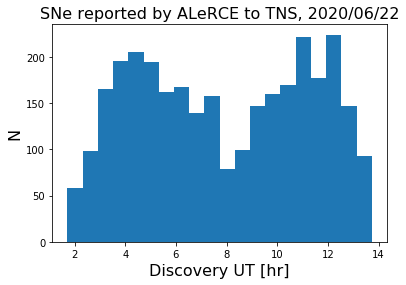

In [46]:
fig, ax = plt.subplots()
ax.hist(df.first_UT, bins=20)
ax.set_xlabel("Discovery UT [hr]", fontsize=16)
ax.set_ylabel("N", fontsize=16)
if mode=="tns":
    ax.set_title("SNe reported by ALeRCE to TNS, %i/%02i/%02i" % 
                 (now.year, now.month, now.day), fontsize = 16)
elif mode=="all":
    ax.set_title("SNe identified by ALeRCE, %i/%02i/%02i" % 
                 (now.year, now.month, now.day), fontsize = 16)
plt.savefig("plots/discovery_UT.png")

print(np.mean(df.first_UT), np.std(df.first_UT))

### Histogram of RA DEC coordinates

In [47]:
import ephem

In [48]:
df["ecl_lat"] = df.apply(lambda row: np.rad2deg(ephem.Ecliptic(ephem.Equatorial('%s' % (row.ra / 15.), '%s' % row.dec, epoch=ephem.J2000)).lat), axis=1)
retracted = pd.read_csv("retracted.txt").oid.to_list()

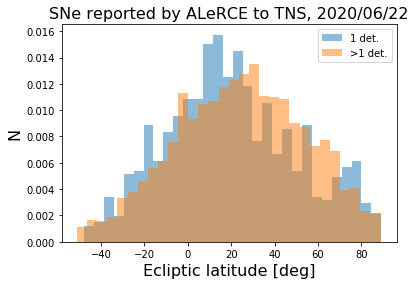

In [49]:
fig, ax = plt.subplots()
mask = df.nobs == 1
ax.hist(df.ecl_lat[mask], bins=30, label="1 det.", alpha=0.5, density=True)
ax.hist(df.ecl_lat[~mask], bins=30, label=">1 det.", alpha=0.5, density=True)
ax.legend()
ax.set_xlabel("Ecliptic latitude [deg]", fontsize=16)
ax.set_ylabel("N", fontsize=16)
if mode=="tns":
    ax.set_title("SNe reported by ALeRCE to TNS, %i/%02i/%02i" % 
                 (now.year, now.month, now.day), fontsize = 16)
elif mode=="all":
    ax.set_title("SNe identified by ALeRCE, %i/%02i/%02i" % 
                 (now.year, now.month, now.day), fontsize = 16)
plt.savefig("plots/discovery_ecl_lat.png")


### Cumulative distribution of MJD times

SNe identified by ALeRCE (average 9.2 SN/day), 2020/06/22
3060
58690.1689815 59021.2381134001


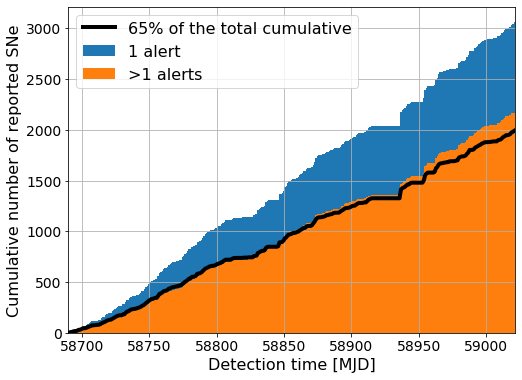

In [50]:
fig, ax = plt.subplots(figsize = (8, 6))
x, y, _ = ax.hist(df.first_mjd, bins = np.linspace(df.first_mjd.min(), df.first_mjd.max(), df.first_mjd.max() - df.first_mjd.min() + 1), cumulative = True, label="1 alert")
ax.set_xlabel("Detection time [MJD]", fontsize = 16)
ax.grid(which='both')
ax.set_ylabel("Cumulative number of reported SNe", fontsize = 16)
if mode=="tns":
    ax.set_title("SNe reported by ALeRCE to TNS (average %.1f SN/day), %i/%02i/%02i" % 
                 (len(oids) / (df.first_mjd.max() - df.first_mjd.min()), now.year, now.month, now.day), fontsize = 16)
elif mode=="all":
    ax.set_title("SNe identified by ALeRCE (average %.1f SN/day), %i/%02i/%02i" % 
                 (df.shape[0] / (df.first_mjd.max() - df.first_mjd.min()), now.year, now.month, now.day), fontsize = 16)
ax.set_title("")
print("SNe identified by ALeRCE (average %.1f SN/day), %i/%02i/%02i" % 
                 (df.shape[0] / (df.first_mjd.max() - df.first_mjd.min()), now.year, now.month, now.day))
efficiency = 0.65
plt.savefig("plots/firstmjd.png")
ax.hist(df[df.nobs > 1].first_mjd, bins = np.linspace(df.first_mjd.min(), df.first_mjd.max(), df.first_mjd.max() - df.first_mjd.min() + 1), cumulative = True, label=">1 alerts")
ax.plot((y[:-1] + y[1:]) / 2, x * efficiency ,c = 'k', label="%i%% of the total cumulative" % (efficiency * 100.), lw=4)
ax.legend(fontsize=16)
plt.tick_params(labelsize=14)
plt.xlim([df.first_mjd.min(), df.first_mjd.max()])
plt.savefig("plots/firstmjd_efficiency_%s.png" % mode, bbox_inches="tight")
plt.savefig("plots/firstmjd_efficiency_%s.pdf" % mode, bbox_inches="tight")

print(len(df.first_mjd))
print(df.first_mjd.min(), df.first_mjd.max())

# Do mosaic of stamps

In [51]:
def plot_stamp(self, oid, candid=None):
    'plot stamp in a notebook given oid. It uses IPython HTML.'

    # if candid is None, get minimum candid                                                                                                                                                                    
    if candid is None:
        candid = min(self.get_detections(oid).index)

    science = "http://avro.alerce.online/get_stamp?oid=%s&candid=%s&type=science&format=png" % (oid, candid)
    images="""                                                                                                                                                                                                 
    <div>ZTF oid: %s, candid: %s</div>                                                                                                                                                                         
    <div>&emsp;&emsp;&emsp;&emsp;&emsp;                                                                                                                                                                        
    Science                                                                                                                                                                                                    
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;                                                                                                                                   
    Template                                                                                                                                                                                                   
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;                                                                                                                                   
    Difference                                                                                                                                                                                                 
    <div class="container">                                                                                                                                                                                    
    <div style="float:left;width:20%%"><img src="%s"></div>                                                                                                                                                    
    <div style="float:left;width:20%%"><img src="%s"></div>                                                                                                                                                    
    <div style="float:left;width:20%%"><img src="%s"></div>                                                                                                                                                    
    </div>                                                                                                                                                                                                     
    """ % (oid, candid, science, science.replace("science", "template"), science.replace("science", "difference"))
    display(HTML(images))


# Distribution of number of detections

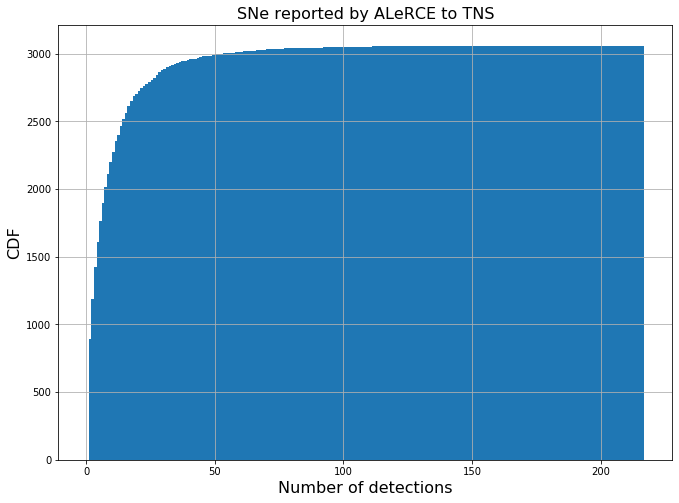

In [52]:
fig, ax = plt.subplots(figsize = (11, 8))
ax.hist(df.nobs, bins = np.linspace(0, df.nobs.max(), df.nobs.max() + 1), cumulative = True)
ax.set_xlabel("Number of detections", fontsize = 16)
ax.grid(which='both')
ax.set_ylabel("CDF", fontsize = 16)
ax.set_title("SNe reported by ALeRCE to TNS", fontsize = 16)
plt.savefig("plots/nobs.png")

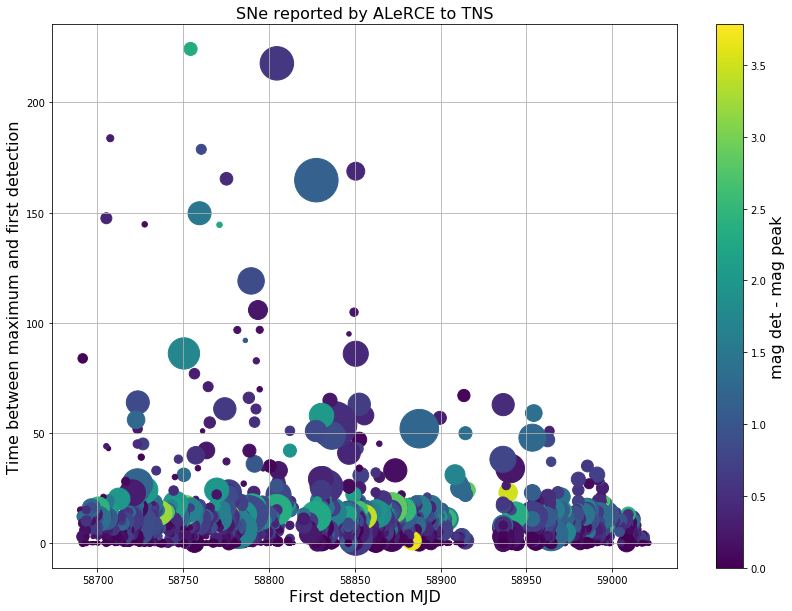

In [53]:
fig, ax = plt.subplots(figsize = (14, 10))
sc = ax.scatter(df.first_mjd, df.dt_first_max, s = 10 * df.nobs, c = df.dmag_first_max)
cbar = fig.colorbar(sc)
cbar.set_label("mag det - mag peak", fontsize=16)
ax.set_xlabel("First detection MJD", fontsize = 16)
ax.grid(which='both')
ax.set_ylabel("Time between maximum and first detection", fontsize = 16)
ax.set_title("SNe reported by ALeRCE to TNS", fontsize = 16)
plt.savefig("plots/dt_first_max_firstMJD.png")

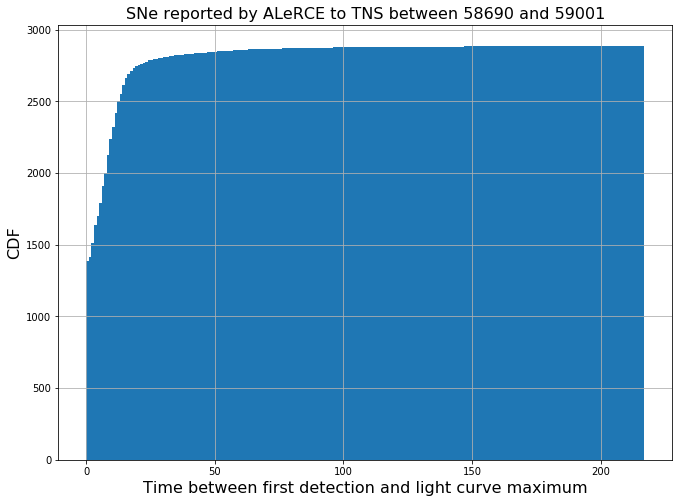

In [54]:
fig, ax = plt.subplots(figsize = (11, 8))
ax.hist(df.dt_first_max[df.first_mjd < df.first_mjd.max() - 20], bins = np.linspace(0, df.nobs.max(), df.nobs.max() + 1), cumulative = True)
ax.set_xlabel("Time between first detection and light curve maximum", fontsize = 16)
ax.grid(which='both')
ax.set_ylabel("CDF", fontsize = 16)
ax.set_title("SNe reported by ALeRCE to TNS between %i and %i" % (df.first_mjd.min(), df.first_mjd.max() - 20), fontsize = 16)
plt.savefig("plots/dt_first_mag.png")

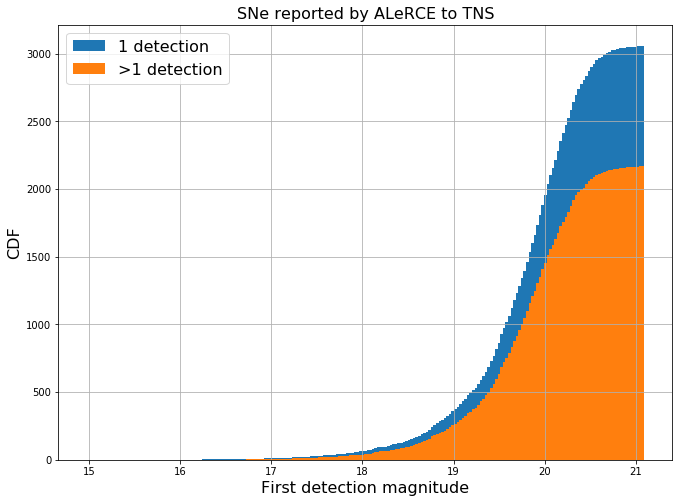

In [55]:
fig, ax = plt.subplots(figsize = (11, 8))
ax.hist(df.first_det_mag, bins = np.linspace(df.first_det_mag.min(), df.first_det_mag.max(), df.nobs.max() + 1), cumulative = True, label="1 detection")
ax.hist(df[df.nobs > 1].first_det_mag, bins = np.linspace(df.first_det_mag.min(), df.first_det_mag.max(), df.nobs.max() + 1), cumulative = True, label=">1 detection")
ax.legend(fontsize=16)
ax.set_xlabel("First detection magnitude", fontsize = 16)
ax.grid(which='both')
ax.set_ylabel("CDF", fontsize = 16)
ax.set_title("SNe reported by ALeRCE to TNS", fontsize = 16)
plt.savefig("plots/mags.png")

3060 SNe reported (excluding 21 retracted)
Average number of detections: 12
Median number of detections: 7
Fraction of candidates with >1 detections: 0.708824
SNe with time between 1st detection and last non-detection < 1 day: 409
SNe with time between 2nd detection and last non-detection < 1 day: 117
Average time between 1st detection and last non-detection: 5.99 [days]
Average time between 2nd detection and last non-detection: 9.64 [days]
STD time between 2nd detection and last non-detection: 6.11 [days]
STD time between 2nd detection and last non-detection: 11.22 [days]


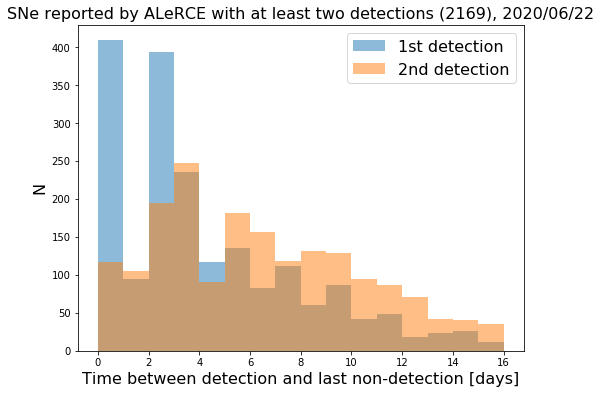

In [56]:
fig, ax = plt.subplots(figsize = (8, 6))
ax.hist(df.dt[df.nobs > 1], alpha = 0.5, bins = np.linspace(0, 16, 17), label = "1st detection" )
ax.hist(df.dt2[df.nobs > 1], alpha = 0.5, bins = np.linspace(0, 16, 17), label = "2nd detection")
ax.set_xlabel("Time between detection and last non-detection [days]", fontsize = 16)
print("%i SNe reported (excluding %i retracted)" % (df.nobs.shape[0], len(retracted)))
print("Average number of detections: %i" % np.average(df.nobs[df.nobs > 1]))
print("Median number of detections: %i" % np.median(df.nobs[df.nobs > 1]))
print("Fraction of candidates with >1 detections: %f" % (np.sum(df.nobs > 1) / df.nobs.shape[0]))
print("SNe with time between 1st detection and last non-detection < 1 day: %i" % np.sum(df.dt[df.nobs > 1] < 1))
print("SNe with time between 2nd detection and last non-detection < 1 day: %i" % np.sum(df.dt2[df.nobs > 1] < 1))
print("Average time between 1st detection and last non-detection: %4.2f [days]" % np.mean(df.dt[df.nobs > 1]))
print("Average time between 2nd detection and last non-detection: %4.2f [days]" % np.mean(df.dt2[df.nobs > 1]))
print("STD time between 2nd detection and last non-detection: %4.2f [days]" % np.std(df.dt[df.nobs > 1]))
print("STD time between 2nd detection and last non-detection: %4.2f [days]" % np.std(df.dt2[df.nobs > 1]))
ax.set_ylabel("N", fontsize = 16)
ax.legend(fontsize = 16)
if mode=="tns":
    ax.set_title("SNe reported by ALeRCE with at least two detections (%i), %i/%02i/%02i" % (np.sum(df.nobs > 1), now.year, now.month, now.day), fontsize = 16)
elif mode=="all":
    ax.set_title("SNe identified by ALeRCE with at least two detections (%i), %i/%02i/%02i" % (np.sum(df.nobs > 1), now.year, now.month, now.day), fontsize = 16)
plt.savefig("plots/TimeSinceDetection_%s.png" % mode)
plt.savefig("plots/TimeSinceDetection_%s.pdf" % mode)

[2.9793287 2.0426621 0.0986922 ... 2.9940625 7.0421991 0.0276505]
3060 SNe reported (excluding 21 retracted)
Average number of detections: 12
Median number of detections: 7
Fraction of candidates with >1 detections: 0.708824
SNe with time between 1st detection and last non-detection < 1 day: 780
SNe with time between 2nd detection and last non-detection < 1 day: 117
Average time between 1st detection and last non-detection: 5.27 [days]
Average time between 2nd detection and last non-detection: 9.64 [days]
STD time between 1nd detection and last non-detection: 5.91 [days]
STD time between 2nd detection and last non-detection: 11.22 [days]
Title SNe reported by ALeRCE with at least two detections (2169), 2020/06/22


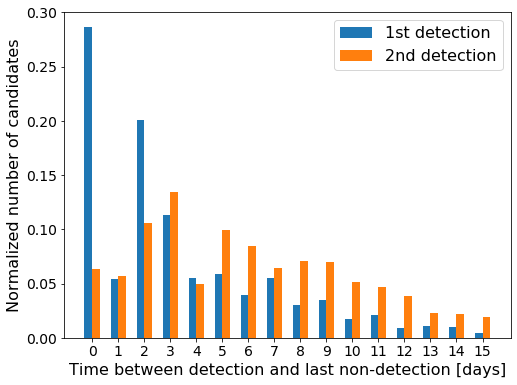

In [57]:
fig, ax = plt.subplots(figsize = (8, 6))
density = True
bins = np.linspace(0, 16, 17)
print(df.dt[df.nobs > 1].values)
h1, _ = np.histogram(df.dt.values, bins=bins, density=density)
h2, _ = np.histogram(df.dt2[df.nobs > 1].values, bins=bins, density=density)
width = 0.3
h1_x = bins - 0.15
h2_x = bins + 0.15
ax.bar(h1_x[0:-1], h1, width=width, label="1st detection")
ax.bar(h2_x[0:-1], h2, width=width, label="2nd detection")
plt.tick_params(labelsize=14)
ax.set_xticks(bins[:-1])

ax.set_xlabel("Time between detection and last non-detection [days]", fontsize = 16)
print("%i SNe reported (excluding %i retracted)" % (df.nobs.shape[0], len(retracted)))
print("Average number of detections: %i" % np.average(df.nobs[df.nobs > 1]))
print("Median number of detections: %i" % np.median(df.nobs[df.nobs > 1]))
print("Fraction of candidates with >1 detections: %f" % (np.sum(df.nobs > 1) / df.nobs.shape[0]))
print("SNe with time between 1st detection and last non-detection < 1 day: %i" % np.sum(df.dt < 1))
print("SNe with time between 2nd detection and last non-detection < 1 day: %i" % np.sum(df.dt2[df.nobs > 1] < 1))
print("Average time between 1st detection and last non-detection: %4.2f [days]" % np.mean(df.dt))
print("Average time between 2nd detection and last non-detection: %4.2f [days]" % np.mean(df.dt2[df.nobs > 1]))
print("STD time between 1nd detection and last non-detection: %4.2f [days]" % np.std(df.dt))
print("STD time between 2nd detection and last non-detection: %4.2f [days]" % np.std(df.dt2[df.nobs > 1]))
ax.set_ylabel("Normalized number of candidates", fontsize = 16)
ax.legend(fontsize = 16)
#if mode=="tns":
#    ax.set_title("SNe reported by ALeRCE with at least two detections (%i), %i/%02i/%02i" % (np.sum(df.nobs > 1), now.year, now.month, now.day), fontsize = 16)
#elif mode=="all":
#    ax.set_title("SNe identified by ALeRCE with at least two detections (%i), %i/%02i/%02i" % (np.sum(df.nobs > 1), now.year, now.month, now.day), fontsize = 16)
print("Title", "SNe reported by ALeRCE with at least two detections (%i), %i/%02i/%02i" % (np.sum(df.nobs > 1), now.year, now.month, now.day))
plt.savefig("plots/TimeSinceDetection_%s.png" % mode, bbox_inches="tight")
plt.savefig("plots/TimeSinceDetection_%s.pdf" % mode, bbox_inches="tight")

# Show number of SNe with a lower non-detection in the same filter within the last 25 hr

Index(['ZTF20aavwppy', 'ZTF20aapycrh', 'ZTF20aaifyab', 'ZTF19adcbxkw',
       'ZTF19abvdgqo', 'ZTF19abueupg'],
      dtype='object', name='oid')


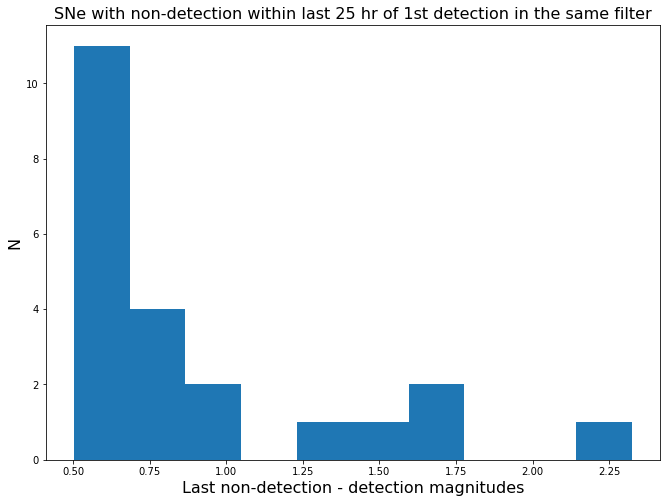

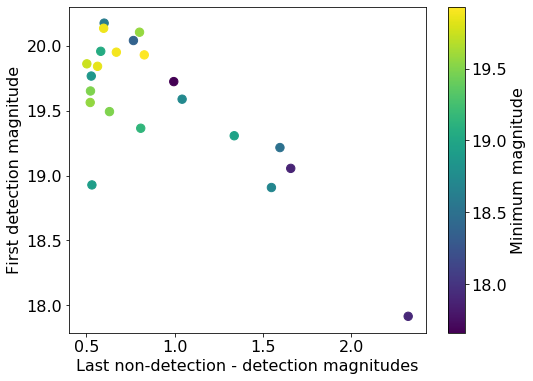

In [57]:
fig, ax = plt.subplots(figsize = (11, 8))
lasthr = 25.
mask = (df.dmag_fid.notna())  & (df.dmag_fid > 0.5) & (df.dt_fid <= lasthr / 24.) & (df.nobs > 1)
ax.hist(df.dmag_fid[mask], alpha = 1, bins=10)# cumulative=True)#,
        #label = "%s SNe @ %i/%02i/%02i" % (mask.sum(), now.year, now.month, now.day))#, cumulative=True)
#ax.set_xlabel("Time between detection and last non-detection [days]", fontsize = 16)
#print("%i SNe reported (excluding %i retracted)" % (df.nobs.shape[0], len(retracted)))
#print("Average number of detections: %i" % np.average(df.nobs[df.nobs > 1]))
#print("Median number of detections: %i" % np.median(df.nobs[df.nobs > 1]))
#print("Fraction of candidates with >1 detections: %f" % (np.sum(df.nobs > 1) / df.nobs.shape[0]))
#print("SNe with time between 1st detection and last non-detection < 1 day: %i" % np.sum(df.dt[df.nobs > 1] < 1))
#print("SNe with time between 2nd detection and last non-detection < 1 day: %i" % np.sum(df.dt2[df.nobs > 1] < 1))
#print("Median time between 1st detection and last non-detection: %4.2f [days]" % np.median(df.dt[df.nobs > 1]))
#print("Median time between 2nd detection and last non-detection: %4.2f [days]" % np.median(df.dt2[df.nobs > 1]))
ax.set_xlabel("Last non-detection - detection magnitudes", fontsize = 16)
ax.set_ylabel("N", fontsize = 16)
ax.set_title("SNe with non-detection within last %i hr of 1st detection in the same filter" % (lasthr), fontsize = 16)
#ax.legend(fontsize=16, loc = 1)
plt.savefig("plots/Deltamag.png")
plt.savefig("plots/Deltamag.pdf")
print(df.loc[mask & (df.dmag_fid > 1)].index)


fig, ax = plt.subplots(figsize=(8, 6))
sc = ax.scatter(df.dmag_fid[mask], df.first_det_mag[mask], c = df.mag_at_max[mask], s=70)
cbar = fig.colorbar(sc, ticks =[18, 18.5, 19, 19.5, 20])
cbar.set_label('Minimum magnitude', fontsize=16)
cbar.ax.tick_params(which='major',labelsize=16)
ax.set_xlabel("Last non-detection - detection magnitudes", fontsize = 16)
ax.set_ylabel("First detection magnitude", fontsize = 16)
ax.tick_params(axis='both', which='major', labelsize=16)
plt.savefig("plots/mag_dmag.png")

for oid in mask[mask].index:
    display(HTML("<a href='http://alerce.online/object/%s'> %s <a>" % (oid, oid)))

33


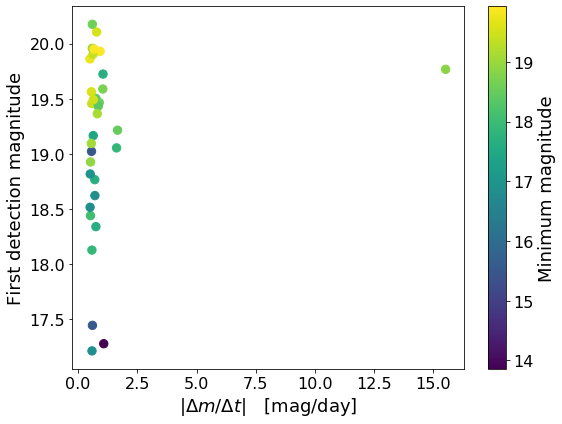

In [58]:
mask =  (df.dmdt_fid.notna()) & (df.dmdt_fid > 0.5) & (df.dmdt_fid < 20) & (df.dmag_fid > 0.5)  & (df.nobs>1)
print(mask.sum())

fig, ax = plt.subplots(figsize=(8, 6))
sc = ax.scatter(df.dmdt_fid[mask], df.first_det_mag[mask], c = df.mag_at_max[mask], s=70)
cbar = fig.colorbar(sc)#, ticks =[17, 17.18, 18.5, 19, 19.5, 20])
cbar.set_label('Minimum magnitude', fontsize=18)
cbar.ax.tick_params(which='major',labelsize=16)
ax.set_xlabel(r"$|\Delta m/ \Delta t|$   [mag/day]", fontsize = 18)
ax.set_ylabel("First detection magnitude", fontsize = 18)
ax.tick_params(axis='both', which='major', labelsize=16)
plt.tight_layout()
plt.savefig("plots/dmdt.png")

for oid in mask[mask].index:
    display(HTML("<a href='http://alerce.online/object/%s'> %s <a>" % (oid, oid)))

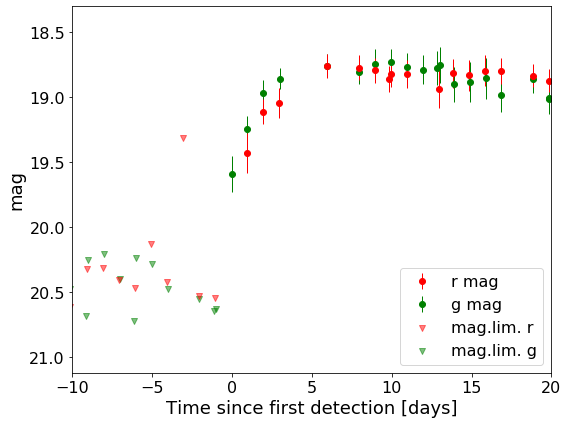

In [59]:
oid = 'ZTF19abueupg'#'ZTF19abvdgqo'
det = alerce.get_detections(oid, format='pandas')
nondet = alerce.get_non_detections(oid, format='pandas')
fig, ax = plt.subplots(figsize=(8,6))
colors = {1: 'g', 2: 'r'}
mjd0 = det.mjd.min()
for fid in [1, 2]:
    mask = det.fid == fid
    ax.errorbar(det.mjd[mask] - mjd0, det.magpsf[mask], yerr=det.sigmapsf[mask], marker='o', lw=0, elinewidth=1, c=colors[fid], label="%s mag" % colors[fid])
    mask = (nondet.fid == fid) & (nondet.index < det.mjd.min())
    ax.scatter(nondet.index[mask] - mjd0, nondet.diffmaglim[mask], marker='v', c=colors[fid], alpha=0.5, label="mag.lim. %s" % colors[fid])
ax.set_ylim(ax.get_ylim()[1], 18.3)
ax.set_xlim(-10, 20)
ax.tick_params(axis='both', which='major', labelsize=16)
#ax.tick_params(axis='y', which='major', labelsize=16)
ax.set_xlabel("Time since first detection [days]", fontsize=18)
ax.set_ylabel("mag", fontsize=18)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], fontsize=16, loc=4)
plt.tight_layout()
plt.savefig("BestSN.png")

# Find distribution of time between detection and 5th detection in the same band

In [60]:
mask = (df.nobs > 5)
dt_5th = {}
for oid in df[mask].index:
    mask = all_detections.oid == oid
    for fid in all_detections[mask].fid.unique():
        mask = (all_detections.oid == oid) & (all_detections.fid == fid)
        if mask.sum() == 0:
            continue
        fid_mjds = all_detections[mask].mjd.values
        if len(fid_mjds) > 4:
            if oid in dt_5th.keys():
                dt_5th[oid] = min(dt_5th[oid], fid_mjds[4] - df.loc[oid].first_mjd)
            else:
                dt_5th[oid] = fid_mjds[4] - df.loc[oid].first_mjd

In [ ]:
fig, ax = plt.subplots()
ax.hist(dt_5th.values(), bins=25)
print(np.percentile(np.array(list(dt_5th.values())), 5))
print(np.median(np.array(list(dt_5th.values()))))
print(np.percentile(np.array(list(dt_5th.values())), 95))
len(dt_5th)

In [ ]:
mask = (df.nobs > 5) & (df.dmag_fid > 0) & (df.dt_fid <= lasthr / 24.)
ax.hist(df.dmag_fid[mask].dropna(), alpha = 0.5, bins=20, label = "%s SNe @ %i/%02i/%02i" % (mask.sum(), now.year, now.month, now.day))
#ax.set_xlabel("Time between detection and last non-detection [days]", fontsize = 16)
#print("%i SNe reported (excluding %i retracted)" % (df.nobs.shape[0], len(retracted)))
#print("Average number of detections: %i" % np.average(df.nobs[df.nobs > 1]))
#print("Median number of detections: %i" % np.median(df.nobs[df.nobs > 1]))
#print("Fraction of candidates with >1 detections: %f" % (np.sum(df.nobs > 1) / df.nobs.shape[0]))
#print("SNe with time between 1st detection and last non-detection < 1 day: %i" % np.sum(df.dt[df.nobs > 1] < 1))
#print("SNe with time between 2nd detection and last non-detection < 1 day: %i" % np.sum(df.dt2[df.nobs > 1] < 1))
#print("Median time between 1st detection and last non-detection: %4.2f [days]" % np.median(df.dt[df.nobs > 1]))
#print("Median time between 2nd detection and last non-detection: %4.2f [days]" % np.median(df.dt2[df.nobs > 1]))
ax.set_xlabel("Last non-detection - detection magnitudes", fontsize = 16)
ax.set_ylabel("N", fontsize = 16)
ax.set_title("Rising SNe reported by ALeRCE, non-det. within last %i hr of 1st det. in same filter" % (lasthr), fontsize = 16)
ax.legend(fontsize=16, loc = 1)
plt.savefig("plots/Deltamag.png")
plt.savefig("plots/Deltamag.pdf")
print(df.loc[mask & (df.dmag_fid > 1)].index)

In [ ]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper
from bokeh.models import ColumnDataSource, OpenURL, TapTool

output_notebook()

In [ ]:
df["nobs_t"] = 5 + df.nobs
df["dmdt"] = df.dmag_fid / df.dt_fid

In [ ]:
from bokeh.palettes import Spectral10
from bokeh.palettes import Viridis256
from bokeh.transform import linear_cmap


p = figure(
    plot_width = 800,
    plot_height = 600,
    tools=('pan, wheel_zoom, box_zoom, reset, tap')
)
p.add_tools(HoverTool(tooltips="""
<div>
    <div><span style='font-size: 12px'>oid: @oid</span></div>    
    <div><span style='font-size: 12px'>nobs: @nobs</span></div>    
    <div><span style='font-size: 12px'>dt: @dt</span></div>    
    <div><span style='font-size: 12px'>dt2: @dt2</span></div>    
    <div><span style='font-size: 12px'>dt_fid: @dt_fid</span></div>
    <div><span style='font-size: 12px'>dmag_fid: @dmag_fid</span></div>
    <div><span style='font-size: 12px'>first_mjd: @first_mjd</span></div>
    <div><span style='font-size: 12px'>dmdt: @dmdt</span></div>

</div>
"""))

taptool = p.select(type = TapTool)
url = "http://dev.alerce.online/vue/object/@oid"
taptool.callback = OpenURL(url=url)

color_col = 'first_mjd'
mapper = linear_cmap(field_name=color_col, palette=Viridis256,low=df.first_mjd.min(), high=df.first_mjd.max())

x_col = 'dt_fid'
y_col = 'dmag_fid'
size_col = 'nobs_t'
p.circle(
    x_col,
    y_col,
    source = df,
    color = mapper,
    size = size_col,
    line_alpha = 0.6,
    fill_alpha = 0.6
)

p.xaxis.axis_label = x_col
p.yaxis.axis_label = y_col
p.title.text = ("%s vs %s (size: %s, color: %s)" % (x_col, y_col, size_col, color_col))
show(p)


In [ ]:
from bokeh.palettes import Spectral10
from bokeh.palettes import Viridis256
from bokeh.transform import linear_cmap


p = figure(
    plot_width = 1000,
    plot_height = 600,
    tools=('pan, wheel_zoom, box_zoom, reset, tap')
)
p.add_tools(HoverTool(tooltips="""
<div>
    <div><span style='font-size: 12px'>oid: @oid</span></div>    
    <div><span style='font-size: 12px'>nobs: @nobs</span></div>    
    <div><span style='font-size: 12px'>dt: @dt</span></div>    
    <div><span style='font-size: 12px'>dt2: @dt2</span></div>    
    <div><span style='font-size: 12px'>dt_fid: @dt_fid</span></div>
    <div><span style='font-size: 12px'>dmag_fid: @dmag_fid</span></div>
    <div><span style='font-size: 12px'>first_mjd: @first_mjd</span></div>
    <div><span style='font-size: 12px'>dmdt: @dmdt</span></div>

</div>
"""))

taptool = p.select(type = TapTool)
url = "http://alerce.online/vue/object/@oid"
taptool.callback = OpenURL(url=url)

color_col = 'dmag_first_max'
mapper = linear_cmap(field_name=color_col, palette=Viridis256,low=df.dmag_first_max.min(), high=df.dmag_first_max.max())


x_col = 'first_mjd'
y_col = 'dt_first_max'
size_col = 'nobs_t'
p.circle(
    x_col,
    y_col,
    source = df,
    color = mapper,
    size = size_col,
    line_alpha = 0.6,
    fill_alpha = 0.6
)

p.xaxis.axis_label = x_col
p.yaxis.axis_label = y_col
p.title.text = ("%s vs %s (size: %s, color: %s)" % (y_col, x_col, size_col, color_col))
show(p)


In [ ]:
from bokeh.palettes import Spectral10
from bokeh.palettes import Viridis256
from bokeh.transform import linear_cmap


p = figure(
    plot_width = 800,
    plot_height = 600,
    tools=('pan, wheel_zoom, box_zoom, reset, tap')
)
p.add_tools(HoverTool(tooltips="""
<div>
    <div><span style='font-size: 12px'>oid: @oid</span></div>    
    <div><span style='font-size: 12px'>nobs: @nobs</span></div>    
    <div><span style='font-size: 12px'>dt: @dt</span></div>    
    <div><span style='font-size: 12px'>dt2: @dt2</span></div>    
    <div><span style='font-size: 12px'>dt_fid: @dt_fid</span></div>
    <div><span style='font-size: 12px'>dmag_fid: @dmag_fid</span></div>
    <div><span style='font-size: 12px'>first_mjd: @first_mjd</span></div>
    <div><span style='font-size: 12px'>dmdt: @dmdt</span></div>

</div>
"""))

taptool = p.select(type = TapTool)
url = "http://dev.alerce.online/vue/object/@oid"
taptool.callback = OpenURL(url=url)

#sc = ax.scatter(df.dmdt_fid[mask], df.first_det_mag[mask], c = df.mag_at_max[mask], s=70)

mask =  (df.dmdt_fid.notna()) & (df.dmdt_fid > 0.2) & (df.dmdt_fid < 20) & (df.dmag_fid > 0.5)  & (df.nobs>1)
color_col = 'mag_at_max'
mapper = linear_cmap(field_name=color_col, palette=Viridis256,low=df[mask][color_col].min(), high=df[mask][color_col].max())

x_col = 'dmdt_fid'
y_col = 'first_det_mag'
size_col = 'dmag_first_max'
p.circle(
    x_col,
    y_col,
    source = df.loc[mask],
    color = mapper,
    size = 20,
    line_alpha = 0.6,
    fill_alpha = 0.6
)

p.xaxis.axis_label = x_col
p.yaxis.axis_label = y_col
p.title.text = ("%s vs %s (size: %s, color: %s)" % (x_col, y_col, size_col, color_col))
show(p)


In [ ]:
mask.sum()

In [ ]:
fig, ax = plt.subplots()
ax.scatter(df.first_mjd, df.nobs)
ax.set_yscale("log")

In [ ]:
(df.dec < 30).sum() /  (df.dec < 90).sum()

In [ ]:
fig, ax = plt.subplots()
mask = df.dmag > 0
ax.hist(df.nobs[df.dec < 15], cumulative=True, alpha=0.5, label = "dec < 20")
ax.hist(df.nobs[df.dec < 30], cumulative=True, alpha=0.5, label = "dec < 30")
ax.hist(df.nobs[df.dec < 90], cumulative=True, alpha=0.5, label = 'all')
plt.legend()

# Obtain TNS stats (scrapping)

In [ ]:
#results = {}
#specs = {}
#for name in all_alerce.Name.values:
#    objname = name[3:]
#    print(objname, len(results))
#    url = "https://wis-tns.weizmann.ac.il/object/%s" % objname
#    response = requests.get(url)
#    results[objname] = re.findall("cell-time_received.>(.*?)<.*cell-user_name.>(.*?)<.*cell-source_group_name.>(.*?)<.*cell-discovery_date.>(.*?)<.*", response.text)[1:]
#    specs[objname] = re.findall("spectrum.*?cell-id.>.*?cell-obsdate.>(.*?)<.*cell-tel_inst.>(.*?)<.*cell-exptime.>(.*?)<.*cell-observer.>(.*?)<.*", response.text)[1:]

### Save results

In [ ]:
#import pickle
#with open('wis_results.pkl', 'wb') as handle:
#    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)
#with open('wis_specs.pkl', 'wb') as handle:
#    pickle.dump(specs, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Load results

In [ ]:
import pickle
results = pickle.load(open('wis_results.pkl', 'rb'))
specs = pickle.load(open('wis_specs.pkl', 'rb'))

In [ ]:
for SN in list(specs.keys()):
    if specs[SN] == []:
        del specs[SN]

In [ ]:
delta_report = []
delta_2ndreport = []
group_2ndreport = []
delta_clf = []
mjd_disc = []
for SN in results.keys():
    #if not SN in specs.keys():
    #    continue
    report_2nd = 1e99
    clf_date = 1e99
    if len(results[SN]) > 0:
        for r in results[SN]:
            report_day = Time(r[0].replace(" ", "T")).mjd
            disc_day = Time(r[3].replace(" ", "T")).mjd
            disc_group = r[1]
            if disc_group == "ALeRCE":
                first_detection = disc_day
                report_ALeRCE = report_day
                delta_report.append(report_day - first_detection)
                mjd_disc.append(disc_day)
                if SN in specs.keys():
                    if specs[SN] != []:
                        clf_day = Time(specs[SN][0][0].replace(" ", "T")).mjd
                        delta_clf.append(clf_day - first_detection)
            else:
                if report_day < report_2nd:# and disc_group[:3] == "ZTF" :
                    report_2nd = report_day
                    report_group = disc_group
    if report_2nd < 1e99:
        delta_2ndreport.append(report_2nd - first_detection)
        group_2ndreport.append((SN, report_group))
                
                
delta_report = np.array(delta_report)
delta_2ndreport = np.array(delta_2ndreport)
mjd_disc = np.array(mjd_disc)

In [ ]:
cl, n = np.unique(np.array(group_2ndreport)[:, 1], return_counts=True)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.bar(cl, n)
plt.xticks(rotation=90)
ax.set_title("Sources of subsequent TNS reports")
plt.tight_layout()
plt.savefig("plots/OtherSources.png")

In [ ]:
fig, ax = plt.subplots()
ax.scatter(mjd_disc, delta_report)#, bins=100, cumulative=True);

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
refmjd = 58696
ax.hist(delta_report[mjd_disc > refmjd] * 24., bins=1000, cumulative=True, density=True);
ax.set_title("Candidates submitted to TNS since %i/%02i/%02i (%i)" %
             (Time(refmjd, format='mjd').datetime.year,
              Time(refmjd, format='mjd').datetime.month,
              Time(refmjd, format='mjd').datetime.day,
              len(delta_report[mjd_disc > 58697])), fontsize=18)
ax.set_xlabel("Time between ZTF first detection and ALeRCE report to TNS [hr]", fontsize=18)
ax.set_ylabel("CDF", fontsize=18)
plt.savefig("plots/Report_times.png")

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.hist(delta_2ndreport, bins=1000, cumulative=True, density=True);
ax.set_title("Candidates with 2nd report to TNS (%i)" % len(delta_2ndreport), fontsize=18)
ax.set_xlabel("Time between ALeRCE report to TNS and subsequent report [days]", fontsize=18)
ax.set_ylabel("CDF", fontsize=18)
plt.savefig("plots/ALeRCE_vs_rest.png")

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.hist(delta_clf, bins=1000, density=True, cumulative=True);
ax.set_title("Candidates with spectroscopic classification (%i)" % len(delta_clf), fontsize=18)
ax.set_xlabel("Time between ALeRCE report to TNS and spec. classification [days]", fontsize=18)
ax.set_ylabel("CDF", fontsize=18)
plt.savefig("plots/ALeRCE_classification.png")

In [ ]:
print(np.median(delta_report[mjd_disc > refmjd]))

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.hist(delta_report[mjd_disc > refmjd], bins=1000, density=True, alpha=0.5, cumulative=True, color = 'r', label='ALeRCE');
ax.hist(delta_2ndreport, bins=1000, density=True, alpha=0.5, cumulative=True, label='Other', color = 'gray');
ax.hist(delta_clf, bins=1000, density=True, alpha=0.5, cumulative=True, label='Spectra', color = 'b');
ax.axvline(np.median(delta_report[mjd_disc > refmjd]), c = 'r')
ax.text(np.median(delta_report[mjd_disc > refmjd]), 1.,
        " %.1f hr" % (np.median(delta_report[mjd_disc > refmjd]) * 24.), color = 'r', fontsize=20)
ax.axvline(np.median(delta_2ndreport), c = 'gray')
ax.text(np.median(delta_2ndreport), 1.,
        " %.1f days" % (np.median(delta_2ndreport)), color = 'gray', fontsize=20, rotation=90, ha = 'right')
ax.axvline(np.median(delta_clf), c = 'b')
ax.text(np.median(delta_clf), 1.,
        " %.1f days" % (np.median(delta_clf)), color = 'b', fontsize=20, rotation=90, ha = 'right')
ax.set_title("Candidates sent by ALeRCE", fontsize=18)
ax.set_xlabel("Time between first ZTF detection and report to TNS [days]", fontsize=18)
ax.set_ylabel("CDF", fontsize=18)
ax.set_xlim(0, 25)
ax.legend(fontsize=18, loc=4)
plt.savefig("plots/ALeRCE_Other.pdf")
plt.savefig("plots/ALeRCE_Other.png")

In [ ]:
list(zip(group_2ndreport, delta_2ndreport))

In [ ]:
fig, ax = plt.subplots(figsize = (11, 8))
ax.hist(df.first_det_mag, bins = np.linspace(df.first_det_mag.min(), df.first_det_mag.max(), df.nobs.max() + 1),
        cumulative = True, label="1 detection", density=True, alpha = 0.5, histtype='step', lw=2)
ax.hist(df[df.nobs > 1].first_det_mag, bins = np.linspace(df.first_det_mag.min(), df.first_det_mag.max(), df.nobs.max() + 1),
        cumulative = True, label=">1 detection", density=True, alpha = 0.5, histtype='step', lw=2)
ax.hist(all_alerce.loc[classified_mask]["Discovery Mag"], bins = np.linspace(df.first_det_mag.min(), df.first_det_mag.max(), df.nobs.max() + 1),
        cumulative = True, label="spectroscopically classified", density=True, alpha = 0.5, histtype='step', lw=2)
ax.legend(fontsize=16, loc=2)
ax.set_xlabel("First detection magnitude", fontsize = 16)
#ax.grid(which='both')
ax.set_ylabel("CDF", fontsize = 16)
ax.set_title("SNe reported by ALeRCE to TNS", fontsize = 16)
plt.savefig("plots/mags+clf.png")

In [ ]:
all_alerce["shortname"] = all_alerce.Name.apply(lambda x: x[3:])

In [ ]:
list(all_alerce)

# Do some statistics on ML classified objects

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy import coordinates
from astropy.time import Time
from IPython.display import HTML
from ipywidgets import Layout, Box, widgets

In [ ]:
#!pip install psycopg2-binary
import psycopg2

In [ ]:
import json
credentials_file = "../usecases/alercereaduser_v2.json"
with open(credentials_file) as jsonfile:
    params = json.load(jsonfile)["params"]

In [ ]:
conn = psycopg2.connect(dbname=params['dbname'], user=params['user'], host=params['host'], password=params['password'])

In [ ]:
query = "select tablename from pg_tables where schemaname='public';"
tables = pd.read_sql_query(query, conn)
tables.sort_values(by="tablename")

In [ ]:
alltabs = []
for tab in sorted(tables.tablename):
    cols = pd.DataFrame()
    query = "select column_name, data_type from information_schema.columns where table_name = '%s';" % tab
    results = pd.read_sql_query(query, conn)
    results["table"] = tab
    alltabs.append(results)
dftab = pd.concat(alltabs)
pd.options.display.max_rows = 999
display(dftab[["table", "column_name", "data_type"]])
pd.options.display.max_rows = 101

In [ ]:
query = "select * from class"
classes = pd.read_sql_query(query, conn)
classmapper = dict(zip(classes.name.tolist(), classes.id.tolist()))
classmapper

In [ ]:
fig, ax = plt.subplots(figsize=(20, 12))
ncl = 0
df_cl = {}
for cl in classmapper.keys():
    if cl in ["Other", "EB", "SNe", "AGN", "SN", "Variable Star", "Asteroid", "Bogus"]:
        continue
    ncl += 1
    print(cl)
    prob_name = "%s_prob" % cl.replace(" ", "")
    if cl == "AGN I":
        prob_name = "AGN-I_prob"
    elif cl == "EB/SD/D":
        prob_name = "EBSD/D_prob"
    elif cl == "EB/C":
        prob_name = "EBC_prob"
    elif cl == "Periodic/Other":
        prob_name = "Periodic-Other_prob"
    query='''
    select late_probabilities_v2."%s"
    from late_probabilities_v2 

    inner join objects
    on late_probabilities_v2.oid=objects.oid

    where objects.classrf=%i
    
    ''' % (prob_name, classmapper[cl])
    # notar que "SNIa_prob" is written between parenthesis, since this is a programatically defined column in SQL

    df_cl[prob_name] = pd.read_sql_query(query, conn)
    ax.hist(df_cl[prob_name][prob_name], histtype='step', cumulative=True, bins=20, lw=5, label=cl, alpha=0.8)
    ax.text(df_cl[prob_name][prob_name].max(), df_cl[prob_name].shape[0], cl, fontsize=18, rotation=45, va='bottom', ha='left')
ax.legend(fontsize=18)
ax.set_xlim(0, 1.2)
ax.set_yscale('log')
ax.set_xlabel("Probability")
ax.set_xlabel("CDF")
plt.savefig("plots/cumulative.png")    

In [ ]:
fig, ax = plt.subplots(nrows = len(df_cl.keys()), figsize=(12, 20), sharex=True)
for idx, cl in enumerate(df_cl.keys()):
    print(idx, cl, np.percentile(df_cl[cl][cl], 5.))
    ax[idx].axvline(np.percentile(df_cl[cl][cl], 5.), c='g')
    ax[idx].axvline(np.percentile(df_cl[cl][cl], 50.), c='r')
    ax[idx].axvline(np.percentile(df_cl[cl][cl], 95.), c='g')

    ax[idx].axvline(1/len(df_cl.keys()), c = 'k')
    ax[idx].hist(df_cl[cl][cl], density=True, bins=40, lw=5, label=cl, alpha=0.8)
    ax[idx].text(df_cl[cl][cl].max(), 1., " %s (%i)" % (cl, df_cl[cl].shape[0]), fontsize=18, va='bottom', ha='left')

#ax[-1].set_xlabel("probability")    

# Build histogram given probability cut

In [ ]:
class_order = ['AGN-I', 'Blazar', 'CV/Nova', 'LPV', 'SNIa', 'SNIbc', 'SNII', 'SNIIn',
               'SLSN', 'EBSD/D', 'EBC', 'DSCT', 'RRL', 'Ceph', 'Periodic-Other']

In [ ]:
for prob_lim in np.linspace(0, 1, 100):
    fig, ax = plt.subplots(figsize=(12, 10))

    counts = {}
    for idx, cl in enumerate(class_order[::-1]):
        cl = "%s_prob" % cl
        mask = df_cl[cl][cl] > prob_lim
        if mask.sum() > 0:
            counts[cl] = len(df_cl[cl][cl].loc[mask])
            ax.text(counts[cl], idx, counts[cl])
        else:
            counts[cl] = 1e-3

    ax.barh(range(len(counts.keys())), list(counts.values()))
    ax.set_xscale('log')
    ax.set_xlim(0.5, ax.get_xlim()[1])
    ax.yaxis.set_ticks(range(len(counts.keys())))
    ax.yaxis.set_ticklabels([x[:-5] for x in counts.keys()]);
    ax.set_title("Minimum probability: %.2f" % prob_lim)
    
    plt.savefig("histogram_minprob%.2f.png" % prob_lim)

In [ ]:
supernova = {
        "internal_name": "ZTF19abyikbv"
        }

# construct list of (key,value) pairs
json_data = [('api_key', (None, api_key)),
            ('data', (None, json.dumps(supernova)))]

json_url = url_tns_api + '/get/search'
response = requests.post(json_url, files = json_data)

objname = response.json()["data"]["reply"][0]["objname"]
data = {
        "objname": objname,
        "photometry": "1",
        "spectra": "0"
        }

# construct list of (key,value) pairs
json_data = [('api_key', (None, api_key)),
            ('data', (None, json.dumps(data)))]

json_url = url_tns_api + '/get/object'
response = requests.post(json_url, files = json_data)

groupname = response.json()["data"]["reply"]["source_group"]["group_name"]
photometry = response.json()["data"]["reply"]["photometry"]

# Extract data from TNS (API approach)

# Sandbox or real

In [ ]:
sandbox = False # True: test in sandbox, False: send to real website

# Get API key and url

In [ ]:
if sandbox:
    print("Getting API sandbox key...")
    api_key = open("API_sandbox.key", "r").read()
else:
    print("Getting API key...")
    api_key = open("API.key", "r").read()
    
if sandbox:
    url_tns_api="https://sandbox-tns.weizmann.ac.il/api"
else:
    url_tns_api="https://wis-tns.weizmann.ac.il/api"
    
if not sandbox:
    print("WARNING: submitting to real (not sandbox) TNS website")

In [ ]:
# function for changing data to json format
def format_to_json(source):
    # change data to json format and return
    parsed = json.loads(source, object_pairs_hook = OrderedDict)
    result = json.dumps(parsed, indent = 4)
    return result

In [ ]:
mask = all_alerce["Discovering Group/s"] != "ALeRCE"

In [ ]:
dtALeRCE = {}
telescope_2ndreport = {}

for name in all_alerce.loc[mask].Name.values:
    objname = name[3:]
    data = {
            "objname": objname,
            "photometry": "1",
            "spectra": "0"
            }

    # construct list of (key,value) pairs
    json_data = [('api_key', (None, api_key)),
                ('data', (None, json.dumps(data)))]

    json_url = url_tns_api + '/get/object'
    response = requests.post(json_url, files = json_data)

    groupname = response.json()["data"]["reply"]["source_group"]["group_name"]
    photometry = response.json()["data"]["reply"]["photometry"]
    
    times = []
    telescopes = []
    for i in photometry:
        if i["remarks"][:20] != "[Last non detection]":
            print("   ", objname, i["jd"], i["remarks"], i["telescope"]["name"])
            times.append(float(i["jd"]))
            telescopes.append(i["telescope"]["name"])

    try:
        times = np.array(times)
        telescopes = np.array(telescopes, dtype=str)
        idxsorted = np.argsort(times)
        times = times[idxsorted]
        telescopes = telescopes[idxsorted]
        dtimes = times - times[0]
        mask_rep = (dtimes > 0.5) # remove repetitions within the same night 
        dtimes = dtimes[mask_rep]
        telescopes = telescopes[mask_rep]
        dtALeRCE[objname] = dtimes[0]
        telescope_2ndreport[objname] = telescopes[0]
        print(objname, dtALeRCE[objname], telescope_2ndreport[objname])
        
        if telescope_2ndreport[objname] == "P48":
            print(times, telescopes)
    except:
        print("Error with object %s" % objname)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 10))
ax.hist(dtALeRCE.values(), bins=np.linspace(0, 20, 21));
ax.set_xlabel("Report time difference (other - ALeRCE) [days]", fontsize=16);
ax.set_ylabel("N", fontsize=16)
plt.savefig("plots/Reportdiff.png")